In [1]:
import itertools
import pathlib
import pickle
import sys
import warnings
import shapely
import matplotlib.colors as mcl

import astropy.units as u
import brutus
import brutus.seds
import brutus.utils
import astropy.coordinates as coords
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.cm as cm
import numpy as np
import torch as xp
import torch.optim as optim
import torch.utils.data as td
from astropy.coordinates import Distance, SphericalRepresentation
from astropy.table import QTable
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.flows.base import Flow
from nflows.nn.nets import ResidualNet
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from torch import nn
from tqdm import tqdm

# isort: split
import stream_ml.pytorch as sml
import stream_ml.visualization as smlvis
from stream_ml.pytorch.params import ModelParameter, ModelParameters
from stream_ml.pytorch.params.bounds import ClippedBounds, SigmoidBounds
from stream_ml.pytorch.params.scaler import StandardLocation, StandardLnWidth
from stream_ml.pytorch.builtin import Parallax2DistMod
from stream_ml.visualization.background import \
    exponential_like_distribution as exp_distr
from stream_ml.core.builtin._stats.trunc_skewnorm import logpdf

# isort: split
from helper import isochrone_spline

sys.path.append(pathlib.Path().resolve().parents[0].as_posix())
# isort: split

from jhelum_frame import JhelumFrame

/home/jupyter-nstarman/.conda/envs/sml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder = pathlib.Path(".") / "figures" / "model_Jhelum-iso-(g-r)-splitseparate"
folder.mkdir(parents=True, exist_ok=True)

In [3]:
DATA = pathlib.Path("/home/jupyter-comack/stream_ml/Jhelum/data/").resolve()
DATA

PosixPath('/home/jupyter-comack/stream_ml/Jhelum/data')

In [4]:
rng = np.random.default_rng()
rng

Generator(PCG64) at 0x7FC302931000

In [5]:
jhelum_frame = JhelumFrame()

### Loading in Data

In [6]:
# Read full tables
jhelum_data = QTable.read(DATA / "s5cat_dr3_5.fits")

# make phi1, phi2
jhelum_c = coords.ICRS(
    ra=jhelum_data['ra'],
    dec=jhelum_data['dec'],
    radial_velocity=jhelum_data['vel_calib']*u.km/u.s
).transform_to(jhelum_frame)

jhelum_data['phi1'] = jhelum_c.phi1.to_value(u.deg)
jhelum_data['phi2'] = jhelum_c.phi2.to_value(u.deg)

# Select down to jhelum fields
aau_sel = (  ((jhelum_data['phi1'] > -18) & (jhelum_data['phi1'] < 18))
           & ((jhelum_data['phi2'] > -2) & (jhelum_data['phi2'] < 2)))

jhelum_data = jhelum_data[aau_sel]
jhelum_c = jhelum_c[aau_sel]

# fix bad values in g, r
jhelum_data["decam_g"][jhelum_data["decam_g"] < -90 * u.mag] = np.nan
jhelum_data["decam_r"][jhelum_data["decam_r"] < -90 * u.mag] = np.nan

# sort by phi1 
jhelum_data = jhelum_data[np.argsort(jhelum_data["phi1"])]
jhelum_data["phi2_error"] = 1e-6 * u.deg

In [7]:
jhelum_data['pm_phi1'] = jhelum_c.pm_phi1_cosphi2
jhelum_data['pm_phi2'] = jhelum_c.pm_phi2

In [8]:
s1_mem = QTable.read(DATA / "jhelum_stream1_members.fits")
s1_mem = s1_mem[s1_mem['mp'] > 0.9]
s1_mem_c = coords.ICRS(
    ra=s1_mem['ra'] * u.deg,
    dec=s1_mem['dec'] * u.deg,
    radial_velocity=s1_mem['vgsr']
).transform_to(jhelum_frame)
s1_mem['phi1'] = s1_mem_c.phi1.to_value(u.deg)
s1_mem['phi2'] = s1_mem_c.phi2.to_value(u.deg)

In [9]:
s2_mem = QTable.read(DATA / "jhelum_stream2_members.fits")
s2_mem = s2_mem[s2_mem['mp'] > 0.9]
s2_mem_c = coords.ICRS(
    ra=s2_mem['ra'] * u.deg,
    dec=s2_mem['dec'] * u.deg,
    radial_velocity=s2_mem['vgsr']
).transform_to(jhelum_frame)
s2_mem['phi1'] = s2_mem_c.phi1.to_value(u.deg)
s2_mem['phi2'] = s2_mem_c.phi2.to_value(u.deg)

In [10]:
bhb_mem = QTable.read(DATA / "jhelum_bhb.dat", format='ascii.ecsv')
bhb_mem_c = coords.ICRS(
    ra=bhb_mem['ra'] * u.deg,
    dec=bhb_mem['dec'] * u.deg,
).transform_to(jhelum_frame)
bhb_mem['phi1'] = bhb_mem_c.phi1.to_value(u.deg)
bhb_mem['phi2'] = bhb_mem_c.phi2.to_value(u.deg)
bhb_mem["phi2_error"] = 1e-6 * u.deg
bhb_mem['distmod_est'] = 15.6
bhb_mem['w_distmod'] = 0.35
bhb_mem['w_phi2'] = 0.75
bhb_mem.sort('phi1')
bhb_mem.sort('phi1')

In [11]:
# Data cuts
quality_cuts = (
      (jhelum_data["good_star"] == 1)
    & (np.isnan(jhelum_data['feh50']) | (jhelum_data['feh50'] < -1.0))
    & (np.isnan(jhelum_data['vgsr']) | ((-250 * u.km/u.s < jhelum_data['vgsr']) & (jhelum_data['vgsr'] < 70 * u.km/u.s)))
    & (np.isnan(jhelum_data['pmra']) | ((3 * u.mas/u.yr < jhelum_data['pmra']) & (jhelum_data['pmra'] < 10.5 * u.mas/u.yr)))
    & (np.isnan(jhelum_data['pmdec']) | ((-10.5 * u.mas/u.yr < jhelum_data['pmdec']) & (jhelum_data['pmdec'] < 0.5 * u.mas/u.yr)))
)

jhelum_data_red = (jhelum_data[quality_cuts]).copy()
len(jhelum_data_red)

962

In [12]:
table_astrometric_names = ("phi2", "vgsr", "pmra", "pmdec")
table_astrometric_err_names = ("phi2_error", "vel_calib_std", "pmra_error", "pmdec_error")
table_photometric_names = ("decam_g", "decam_r")
table_photometric_err_names = ()  # TODO
table_metal_names = ("feh50",)
table_metal_err_names = ("feh_std",)
table_names = (
    ("phi1",)
    + tuple(item for pair in zip(table_astrometric_names, table_astrometric_err_names) for item in pair)
    + tuple(item for pair in zip(table_metal_names, table_metal_err_names) for item in pair)
    + table_photometric_names  # table_photometric_err_names
)

renamer = {
    "phi2": "phi2", "phi2_error": "phi2_err",
    "pmra": "pmra", "pmra_error": "pmra_err",
    "pmdec": "pmdec", "pmdec_error": "pmdec_err",
    "pmphi1": "pmphi1", "pmphi1_error": "pmphi1_err",
    "pmphi2": "pmphi2", "pmphi2_error": "pmphi2_err",
    "vgsr": "rv", "vel_calib_std": "rv_err",
    "decam_g": "g", "decam_r": 'r', "parallax": "parallax",
    "distmod": "distmod", "feh50" : "feh", "feh_std": "feh_err",
}

data_real = sml.Data.from_format(
    jhelum_data_red,
    fmt="astropy.table",
    names=table_names,
    renamer=renamer,
)

data = data_real.astype(xp.Tensor, dtype=xp.float32)


# rescale
scaler = sml.utils.StandardScaler.fit(data, names=data.names)

where = sml.Data(
    ~xp.isnan(data.array),  # True where NOT missing
    names=data.names,
)

# Set NaN to median value
data.array[~where.array] = xp.asarray(
    np.repeat(np.nanmedian(data.array, axis=0, keepdims=True),
              len(data), axis=0)[~where.array])

data_real.array[~where.array] = np.repeat(np.nanmedian(data.array, axis=0, keepdims=True), len(data), axis=0)[~where.array]

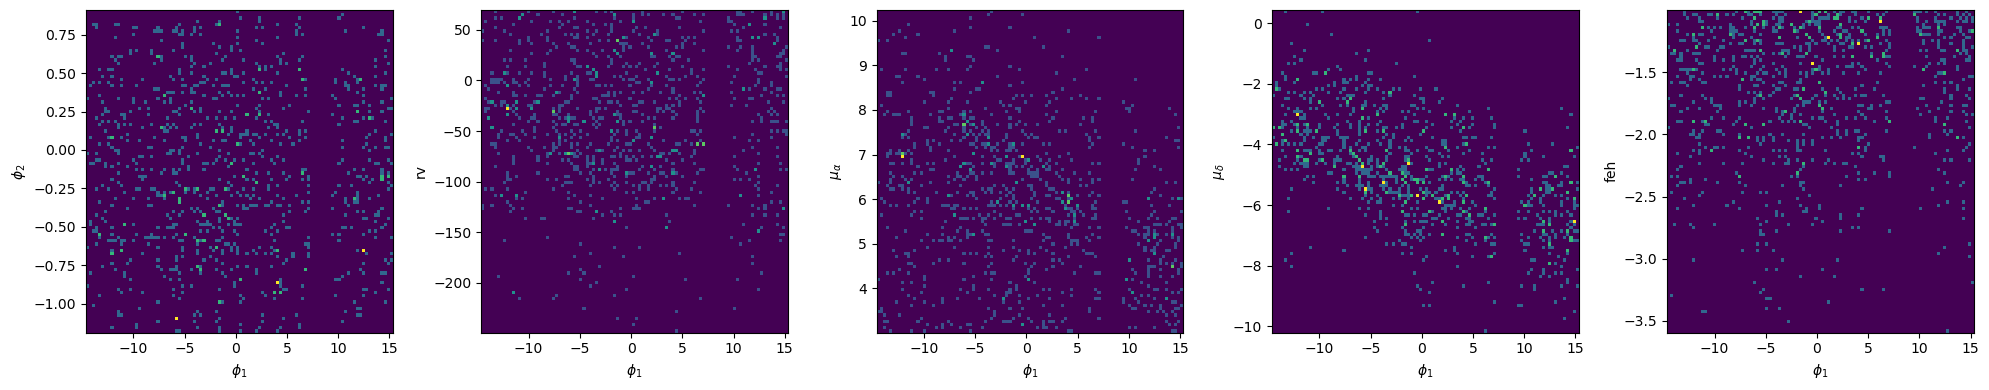

In [13]:
smlvis.coord_panels(
    data_real,
    coords=("phi2", "rv", "pmra", "pmdec", "feh"),
    use_hist=True,
    savefig=str(folder / "selection.png"),
)
plt.show();

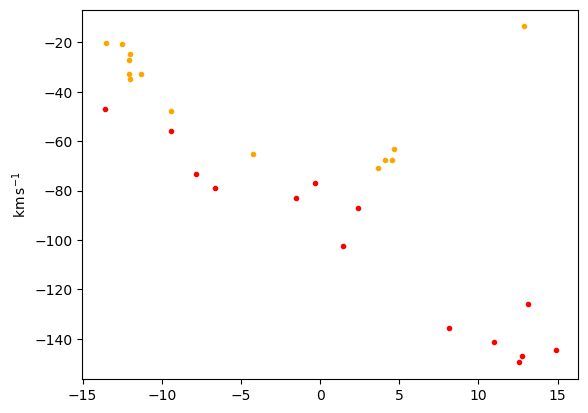

In [14]:
plt.plot(s1_mem['phi1'], s1_mem['vgsr'], c="red", marker='.', linestyle='none', alpha=1)
plt.plot(s2_mem['phi1'], s2_mem['vgsr'], c="orange", marker='.', linestyle='none', alpha=1)

### Building Isochrone

In [15]:
iso_drt = QTable.read(DATA / "jhelum_iso.dat", format='ascii.ecsv')

# manual adjustments
# iso_drt['DECam_g'] = iso_drt['DECam_g'] + 0.030 #0.025
# iso_drt['DECam_r'] = iso_drt['DECam_r'] + 0.009 #0.0

iso_drt['DECam_g'] = iso_drt['DECam_g'] + 0.025 #0.025
iso_drt['DECam_r'] = iso_drt['DECam_r'] + 0.0 #0.0
# iso_drt['g-r'] = (iso_drt['g'])-(iso_drt['r'])

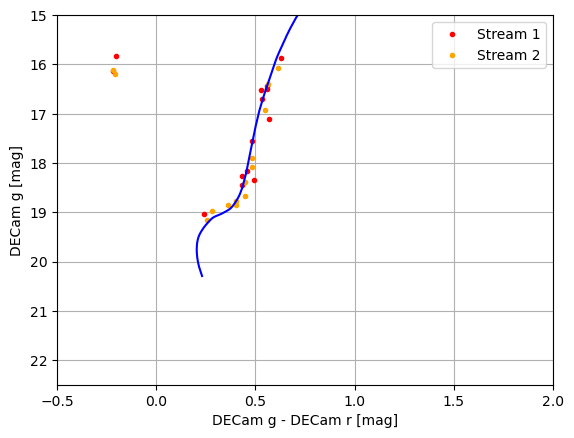

In [74]:
plt.plot(s1_mem['decam_g']-s1_mem['decam_r'], s1_mem['decam_g'], c="red", marker='.', linestyle='none', alpha=1, label='Stream 1')
plt.plot(s2_mem['decam_g']-s2_mem['decam_r'], s2_mem['decam_g'], c="orange", marker='.', linestyle='none', alpha=1, label='Stream 2')
plt.plot(((iso_drt['DECam_g'])-(iso_drt['DECam_r']))[100:], (iso_drt['DECam_g']+15.57)[100:], c="blue")

plt.xlim(-0.5, 2)
plt.ylim((22.5, 15))
plt.grid(True)
plt.legend()
plt.xlabel('DECam g - DECam r [mag]')
plt.ylabel('DECam g [mag]')
plt.show();

In [17]:
s1_mem[[0,2,12,13]][['ra', 'dec', 'decam_g', 'decam_r', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error']]

<QTable length=4>
        ra                 dec         ...        pmdec        pmdec_error
     float64             float64       ...       float64         float32  
------------------ ------------------- ... ------------------- -----------
         320.66815 -45.184105555555554 ...  -6.560053666324865  0.04207006
 343.6860291666667 -51.166830555555556 ... -5.9046564340237095 0.033186924
3.1511833333333334  -51.82100555555556 ...  -3.682508072565031  0.13662684
 323.3486416666667  -46.64360555555556 ...  -7.156508902499533 0.052747298

## Defining Model

In [18]:
coord_astrometric_names = ("phi2", "rv", "pmra", "pmdec")
coord_astrometric_err_names = ("phi2_err", "rv_err", "pmra_err", "pmdec_err")
coord_photometric_names = ("g", "r")
coord_photometric_err_names = ("g_err", "r_err")

coord_names = coord_astrometric_names + coord_photometric_names

In [19]:
coord_bounds: dict[str, tuple[float, float]] = {
    k: (float(np.nanmin(data_real[k])), float(np.nanmax(data_real[k])))
    for k in coord_names
}

# make subselections
coord_astrometric_bounds = {k: coord_bounds[k] for k in coord_astrometric_names}
coord_photometric_bounds = {k: coord_bounds[k] for k in coord_photometric_names}

coord_bounds

{'phi2': (-1.188620153905005, 0.9101846531091293),
 'rv': (-249.1848116455568, 69.6081300784129),
 'pmra': (3.0025293707747553, 10.242970604230033),
 'pmdec': (-10.213167389768339, 0.43763107245362953),
 'g': (15.182658195495605, 19.81113624572754),
 'r': (14.988872528076172, 19.53082847595215)}

### Background Model

In [20]:
background_astrometric_model = sml.builtin.TruncatedSkewNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=3 * len(coord_astrometric_names), dropout=0.15),
    name = 'background_astrometric',
    data_scaler=scaler,
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["phi2"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["rv"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(4, 5),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["pmra"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(0.1, 0.7),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["pmdec"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-0.1, 0.35),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
        }
    ),
)

Background Flow

(-18.0, 18.0)

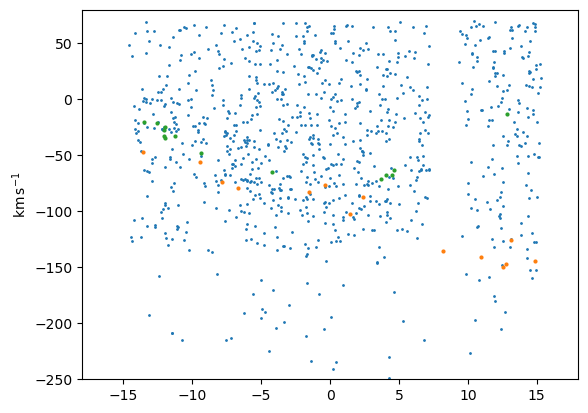

In [21]:
plt.scatter(data['phi1'], data['rv'], s=1)
plt.scatter(s1_mem['phi1'], s1_mem['vgsr'], s=4)
plt.scatter(s2_mem['phi1'], s2_mem['vgsr'], s=4)
plt.ylim((-250, 80))
plt.xlim((-18, 18))

In [22]:
# Background
off_stream = (
    ((data["rv"] > 5) | (data["rv"] < -180))
    & where["g", "r"].array.all(-1)  # no NaN
)

(-18.0, 18.0)

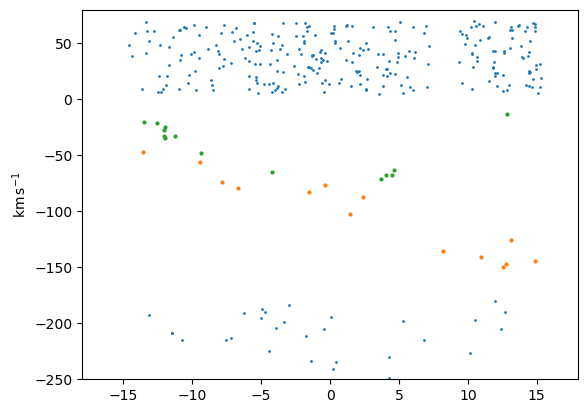

In [23]:
plt.scatter(data['phi1'][off_stream], data['rv'][off_stream], s=1)
plt.scatter(s1_mem['phi1'], s1_mem['vgsr'], s=4)
plt.scatter(s2_mem['phi1'], s2_mem['vgsr'], s=4)
plt.ylim((-250, 80))
plt.xlim((-18, 18))

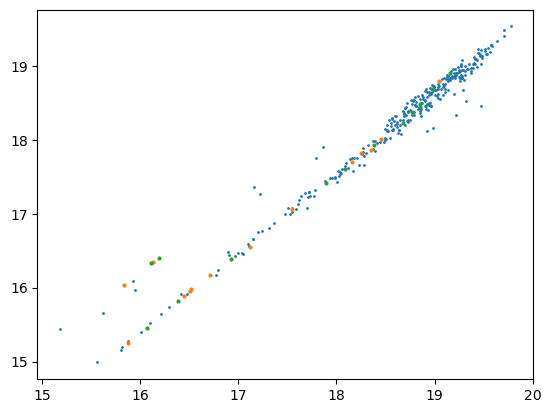

In [24]:
plt.scatter(data['g'][off_stream], data['r'][off_stream], s=1)
plt.scatter(s1_mem['decam_g'], s1_mem['decam_r'], s=4)
plt.scatter(s2_mem['decam_g'], s2_mem['decam_r'], s=4)

In [25]:
num_layers = 4
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=3, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow_coords = ("phi1",) + coord_photometric_names
flow_scaler = scaler[flow_coords]  # slice the StandardScaler

bkg_flow = sml.builtin.compat.FlowModel(
    net=Flow(transform, base_dist),
    name = 'bkg_flow',
    jacobian_logdet=-xp.log(xp.prod(flow_scaler.scale[1:])),
    data_scaler=flow_scaler,
    coord_names=coord_photometric_names,
    coord_bounds=coord_photometric_bounds,
    params=ModelParameters(),
    require_where=True
)

In [26]:
torch_dataset = td.TensorDataset(data[flow_coords][off_stream].array,
                                 where[flow_coords][off_stream].array)
loader = td.DataLoader(dataset=torch_dataset, batch_size=200, shuffle=True, num_workers=0)
optimizer = optim.AdamW(bkg_flow.parameters(), lr=1e-3)

EPOCHS = 1_000

(folder / "flow").mkdir(exist_ok=True, parents=True)
bkg_flow.zero_grad()

# for epoch in tqdm(range(EPOCHS)):

#     for step, (data_cur, dat_where) in enumerate(loader):
#         data_cur = sml.Data(data_cur, names=flow_coords)
#         dat_where = sml.Data(dat_where, names=flow_coords)

#         optimizer.zero_grad()
#         mpars = bkg_flow.unpack_params(bkg_flow(data_cur))
#         loss = - bkg_flow.ln_likelihood_tot(mpars, data_cur, where=dat_where,)

#         loss.backward()
#         optimizer.step()
#         bkg_flow.zero_grad()

#         if epoch % 50 == 0 or epoch == EPOCHS - 1:
#             with xp.no_grad():
#                 mpars = bkg_flow.unpack_params(bkg_flow(data))
#                 lik = bkg_flow.likelihood(mpars, data, where=where,)

#             fig, ax = plt.subplots()
#             im = ax.scatter(data["g"]-data['r'], data["g"], s=1, c=lik)
#             ax.set_xlim((-0.7,1.5))
#             ax.set_ylim((21,14))
#             plt.colorbar(im, ax=ax)
#             fig.savefig(folder / "flow" / f"epoch_{epoch:05}.png")

#             plt.close(fig)

#             xp.save(bkg_flow.state_dict(), folder / "flow" / f"model_{epoch}.pt")

bkg_flow.load_state_dict(xp.load(folder / "flow" / f"model_{EPOCHS-1}.pt"))
object.__setattr__(bkg_flow, "with_grad", False)

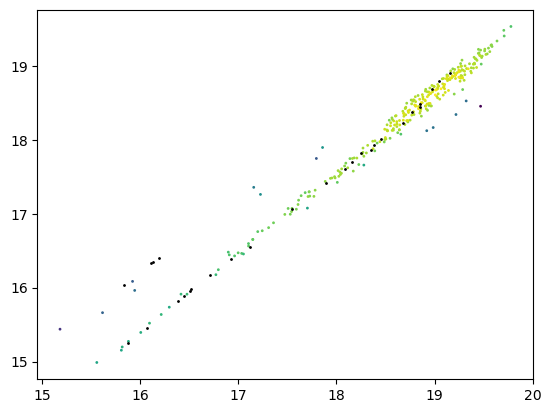

In [27]:
lik = bkg_flow.ln_likelihood(bkg_flow.unpack_params(bkg_flow(data)), data, where=where,)[off_stream]

plt.scatter(data['g'][off_stream], data['r'][off_stream], s=1, c=lik.numpy())
plt.scatter(s1_mem['decam_g'], s1_mem['decam_r'], s=1, c="k")
plt.scatter(s2_mem['decam_g'], s2_mem['decam_r'], s=1, c="k")

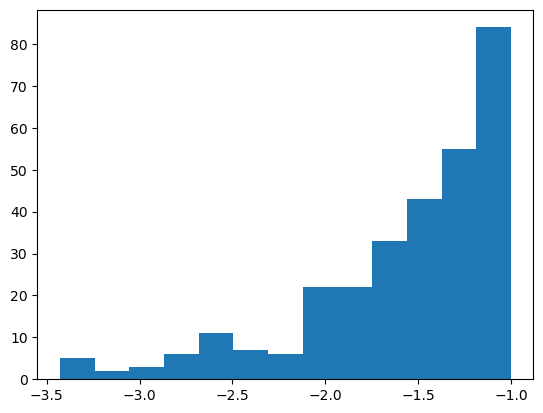

In [28]:
plt.hist(data['feh'][off_stream].numpy(), bins='auto')
plt.show()

In [29]:
background_metal_model = sml.builtin.Exponential(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=16, n_layers=3, n_out=1, dropout=0.15),
    data_scaler=scaler,
    coord_names=("feh", ),
    coord_err_names=('feh_err',),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters({"feh": {"slope": ModelParameter(bounds=SigmoidBounds(-2.0, 0.0), scaler=None)}}),
)

In [30]:
background_model = sml.IndependentModels(
        {
        "astrometric": background_astrometric_model,
        "metal": background_metal_model,
        "photometric": bkg_flow,
    }
)

### Stream Model

In [31]:
# Selection of control points
stream_1_cp = QTable.read(DATA / "jhelum_stream1_cp.ecsv")
stream1_control_points = sml.Data.from_format(stream_1_cp, fmt="astropy.table", names=("phi1", "phi2", "rv", "pmra", "pmdec")).astype(xp.Tensor, dtype=xp.float32)

stream1_control_widths = sml.Data.from_format(stream_1_cp, fmt="astropy.table", names=("w_phi2", "w_rv", "w_pmra", "w_pmdec")).astype(xp.Tensor, dtype=xp.float32)
stream1_control_widths = sml.Data(stream1_control_widths.array, names=("phi2", "rv", "pmra", "pmdec",))

stream1_control_points_prior = sml.prior.ControlRegions(
    center=stream1_control_points,
    lamda=10_000,  # TOO HIGH?
    width=stream1_control_widths,
)

In [32]:
# Selection of control points
stream_2_cp = QTable.read(DATA / "jhelum_stream2_cp.ecsv")
stream2_control_points = sml.Data.from_format(stream_2_cp, fmt="astropy.table", names=("phi1", "phi2", "rv", "pmra", "pmdec")).astype(xp.Tensor, dtype=xp.float32)

stream2_control_widths = sml.Data.from_format(stream_2_cp, fmt="astropy.table", names=("w_phi2", "w_rv", "w_pmra", "w_pmdec")).astype(xp.Tensor, dtype=xp.float32)
stream2_control_widths = sml.Data(stream2_control_widths.array, names=("phi2", "rv", "pmra", "pmdec",))

stream2_control_points_prior = sml.prior.ControlRegions(
    center=stream2_control_points,
    lamda=10_000,  # TOO HIGH?
    width=stream2_control_widths,
)

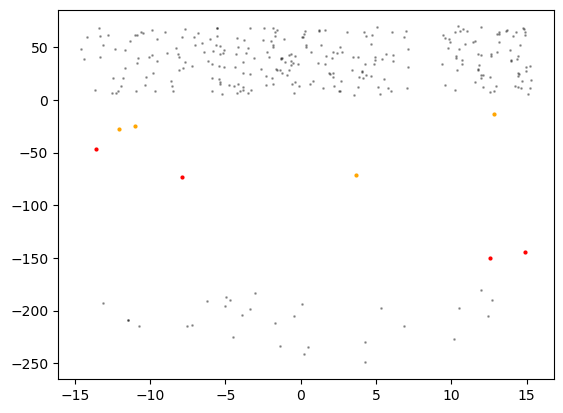

In [33]:
plt.scatter(data['phi1'][off_stream], data['rv'][off_stream], s=1, c='black', alpha=0.3)
plt.scatter(stream1_control_points['phi1'], stream1_control_points['rv'], s=4, c='red')
plt.scatter(stream2_control_points['phi1'], stream2_control_points['rv'], s=4, c='orange')

In [34]:
stream1_astrometric_model = sml.builtin.TruncatedNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2 * len(coord_astrometric_names), dropout=0.15),
    data_scaler=scaler,
    name = 'stream1_astrometric',
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, 2.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.4, 0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-150., 10.),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(4, 8),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-8.0, -3.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.2),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
            },
        }
    ),
    priors=(stream1_control_points_prior,)
)

In [35]:
stream2_astrometric_model = sml.builtin.TruncatedNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2 * len(coord_astrometric_names), dropout=0.15),
    data_scaler=scaler,
    name = 'stream2_astrometric',
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, 2.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.4, 0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-150., 10.),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(4, 8),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-8.0, -3.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.2),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
            },
        }
    ),
    priors=(stream2_control_points_prior,)
)

In [36]:
isochrone_spl = isochrone_spline(
    np.lib.recfunctions.structured_to_unstructured(iso_drt[['DECam_g', 'DECam_r']].as_array())[130:-5],
    xp=np
)

stream_abs_mags = np.lib.recfunctions.structured_to_unstructured(iso_drt[['DECam_g', 'DECam_r']].as_array())[130:-5]

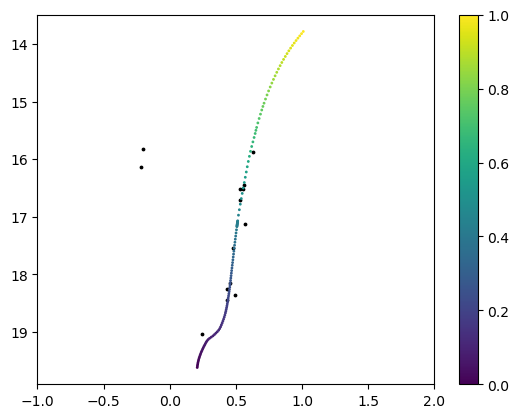

In [37]:
plt.scatter(s1_mem["decam_g"] - s1_mem['decam_r'],
            s1_mem["decam_g"],
            s=3, c="k")
plt.scatter(stream_abs_mags[:,0] - stream_abs_mags[:,1],
            stream_abs_mags[:,0]+15.6,
            c=isochrone_spl.x, s=1)
plt.gca().invert_yaxis()
plt.xlim((-1.0,2))
plt.colorbar()

In [38]:
# Selection of control points
stream_control_points = sml.Data.from_format(bhb_mem, fmt="astropy.table", names=("phi1", "distmod_est"), renamer={'distmod_est':"distmod"}).astype(xp.Tensor, dtype=xp.float32)

stream_control_widths = sml.Data.from_format(bhb_mem, fmt="astropy.table", names=("w_distmod",)).astype(xp.Tensor, dtype=xp.float32)
stream_control_widths = sml.Data(stream_control_widths.array, names=("distmod",))

stream_control_points_prior = sml.prior.ControlRegions(
    center=stream_control_points,
    lamda=10_000,
    width=stream_control_widths,
)

In [39]:
phot_names = ("g", "r",)
phot_bounds = {k: (float(np.nanmin(data[k])), float(np.nanmax(data[k]))) for k in phot_names}

stream1_isochrone_model = sml.builtin.IsochroneMVNorm(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    name = 'stream1_isochrone',
    data_scaler=scaler,
    # coordinates
    coord_names=('distmod',),
    coord_bounds={'distmod' : (14, 20),},
    # photometry
    phot_names=phot_names,
    phot_err_names=None,             #tuple(f"{k}_err" for k in phot_names),
    phot_apply_dm=(True, True),
    phot_bounds=phot_bounds,
    # isochrone
    gamma_edges=xp.linspace(isochrone_spl.x.min(), isochrone_spl.x.max(), 50),
    isochrone_spl=isochrone_spl,
    isochrone_err_spl=None,
#    stream_mass_function=...,
    # params
    params=ModelParameters({
        "distmod": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(10.0,21.0),
                    scaler=None,
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-5.0, 1.5),
                    scaler=None,
                ),
            },
        }
    ),
    priors=(stream_control_points_prior, ),
    require_where=True
)

In [40]:
stream2_isochrone_model = sml.builtin.IsochroneMVNorm(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    name = 'stream2_isochrone',
    # coordinates
    coord_names=('distmod',),
    coord_bounds={'distmod' : (14, 20),},
    # photometry
    phot_names=phot_names,
    phot_err_names=None,             #tuple(f"{k}_err" for k in phot_names),
    phot_apply_dm=(True, True),
    phot_bounds=phot_bounds,
    # isochrone
    gamma_edges=xp.linspace(isochrone_spl.x.min(), isochrone_spl.x.max(), 50),
    isochrone_spl=isochrone_spl,
    isochrone_err_spl=None,
#    stream_mass_function=...,
    # params
    params=ModelParameters({
        "distmod": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(10.0,21.0),
                    scaler=None,
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-5.0, 1.5),
                    scaler=None,
                ),
            },
        }
    ),
    priors=(stream_control_points_prior, ),
    require_where=True
)

In [41]:
stream1_metal_model = sml.builtin.TruncatedNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=64, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    name = 'stream1_metal',
    coord_names=('feh',),
    coord_err_names=("feh_err",),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters(
        {
            "feh": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-3.0, 0.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "feh", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.0, 1),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "feh", xp=xp),
                ),
            },
        }
    ),
)

In [42]:
stream2_metal_model = sml.builtin.TruncatedNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=64, n_layers=4, n_out=2, dropout=0.15),
    name = 'stream2_metal',
    data_scaler=scaler,
    coord_names=('feh',),
    coord_err_names=("feh_err",),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters(
        {
            "feh": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-3.0, 0.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "feh", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.0, 1),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "feh", xp=xp),
                ),
            },
        }
    ),
)

In [43]:
stream1_model = sml.IndependentModels(
        {
        "astrometric": stream1_astrometric_model,
        "photometric": stream1_isochrone_model,
        "metal": stream1_metal_model,
    },
    name = 'stream1_model'
)

In [44]:
stream2_model = sml.IndependentModels(
        {
        "astrometric": stream2_astrometric_model,
        "photometric": stream2_isochrone_model,
        "metal": stream2_metal_model,
    },
    name='stream2_model'
)

In [45]:
# stream_model = sml.IndependentModels(
#         {
#         "stream1": stream1_model,
#         "stream2": stream2_model,
#     },
#     name='stream_model'
# )

### Combined Model

In [46]:
model = sml.MixtureModel(
    {
        "stream1": stream1_model,
        "stream2": stream2_model,
        "background": background_model
    },
    net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    params=ModelParameters(
        {
            "stream1.weight": ModelParameter(
                bounds=SigmoidBounds(1e-2, 0.3), scaler=None
            ),
            "stream2.weight": ModelParameter(
                bounds=SigmoidBounds(1e-2, 0.3), scaler=None
            ),
            "background.weight": ModelParameter(
                bounds=ClippedBounds(0.4, 1.0), scaler=None
            ),
        }
    ),
    priors=(
        sml.prior.HardThreshold(1, upper=-18, param_name="stream1.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, lower=18, param_name="stream1.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, upper=-18, param_name="stream2.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, lower=18, param_name="stream2.weight", coord_name="phi1", data_scaler=scaler),
    ),
)
model.components.keys()

frozen_dict_keys(['stream1', 'stream2', 'background'])

In [47]:
EPOCHS = 20_000  # 5k w/out dropout, 10k with
BATCH_SIZE = int(len(data) * 0.075)

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

In [48]:
dataset = td.TensorDataset(
    data.array,  # data
    where.array,  # mask: TRUE where NOT missing
)

loader = td.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,  # drop rando last for better plotting
)

optimizer = optim.AdamW(
    list(model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1_250, eta_min=1e-5)

In [49]:
model['stream1'].components.keys()

frozen_dict_keys(['astrometric', 'photometric', 'metal'])

In [50]:
(folder / "training").mkdir(parents=True, exist_ok=True)

slopes = np.full((EPOCHS // 100, len(coord_astrometric_names), BATCH_SIZE), np.nan)

num_steps = len(loader.dataset) // loader.batch_size
epoch: int = 0
# for epoch in tqdm(range(EPOCHS)):

#     for step, (step_arr, dat_where) in enumerate(loader):

#         # Prepare
#         step_data = sml.Data(step_arr, names=data.names)
#         dat_where = sml.Data(dat_where, names=data.names)

#         # Forward Step
#         pred = model(step_data)
#         if pred.isnan().any(): raise ValueError

#         mpars = model.unpack_params(pred)
#         loss_val = -model.ln_posterior_tot(
#             mpars,
#             step_data,
#             where=dat_where,
#         )

#         # backward pass
#         optimizer.zero_grad()
#         loss_val.backward()

#         # update weights
#         optimizer.step()
#         scheduler.step(epoch + step / num_steps)

#         model.zero_grad()  # ?

#     if epoch % 100 == 0 or epoch == EPOCHS - 1:
#         model.eval()  # turn off training for nicer plot
        
#         with xp.no_grad():
#             mpars = model.unpack_params(model(data))

#         fig = smlvis.astrometric_model_panels(
#             model,
#             data,
#             mpars,
#             coords=("phi2","rv", "pmra", "pmdec"),
#             components=("stream1.astrometric","stream2.astrometric", "background.astrometric"),
#             min_weight=1e-3,
#             figsize=(12, 4),
#             top_legend_fontsize=8,
#             savefig=folder / "training" / f"epoch-{epoch:05}.png",
#         )
#         plt.close(fig)

#         model.train()  # turn training back on

#     # Serialize
#     if epoch % 500 == 0 or epoch == EPOCHS - 1:
#         xp.save(model.state_dict(), folder / "training" / f"model_{epoch:05}.pt")

model.load_state_dict(xp.load(folder / "training" / f"model_{EPOCHS - 1:05}.pt"))

<All keys matched successfully>

## Plotting

In [51]:
## Get predictions
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream1_lnlik = model.component_ln_posterior("stream1", mpars, data, where=where)
    stream2_lnlik = model.component_ln_posterior("stream2", mpars, data, where=where)
    tot_lnlik = model.ln_posterior(mpars, data, where=where)

stream_prob = np.exp(stream1_lnlik - tot_lnlik) + np.exp(stream2_lnlik-tot_lnlik)
print(stream_prob.min(), stream_prob.max())
#stream_prob[stream_prob > 1] = 1.0

tensor(0.) tensor(1.)


In [52]:
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream1_lnlik = model.component_ln_prior("stream1", mpars, data)
    stream2_lnlik = model.component_ln_prior("stream2", mpars, data)
    bkg_lnlik = model.component_ln_prior("background", mpars, data)

In [53]:
## Get predictions
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream1_lnlik = model.component_ln_likelihood("stream1", mpars, data, where=where)
    stream2_lnlik = model.component_ln_likelihood("stream2", mpars, data, where=where)
    tot_lnlik = model.ln_likelihood(mpars, data, where=where)

stream_prob = np.exp(stream1_lnlik - tot_lnlik) + np.exp(stream2_lnlik-tot_lnlik)
print(stream_prob.min(), stream_prob.max())
stream_prob[stream_prob > 1] = 1.0

tensor(0.) tensor(1.0000)


In [54]:
## Get predictions
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream1_lnlik = model.component_ln_prior("stream1", mpars, data)
    stream2_lnlik = model.component_ln_prior("stream2", mpars, data)
    tot_lnlik = model.ln_prior(mpars, data)

stream1_prob = np.exp((stream1_lnlik) - tot_lnlik)
print(stream1_prob.min(), stream1_prob.max())
stream1_prob[stream1_prob > 1] = 1.0

tensor(1.) tensor(1.)


Combined

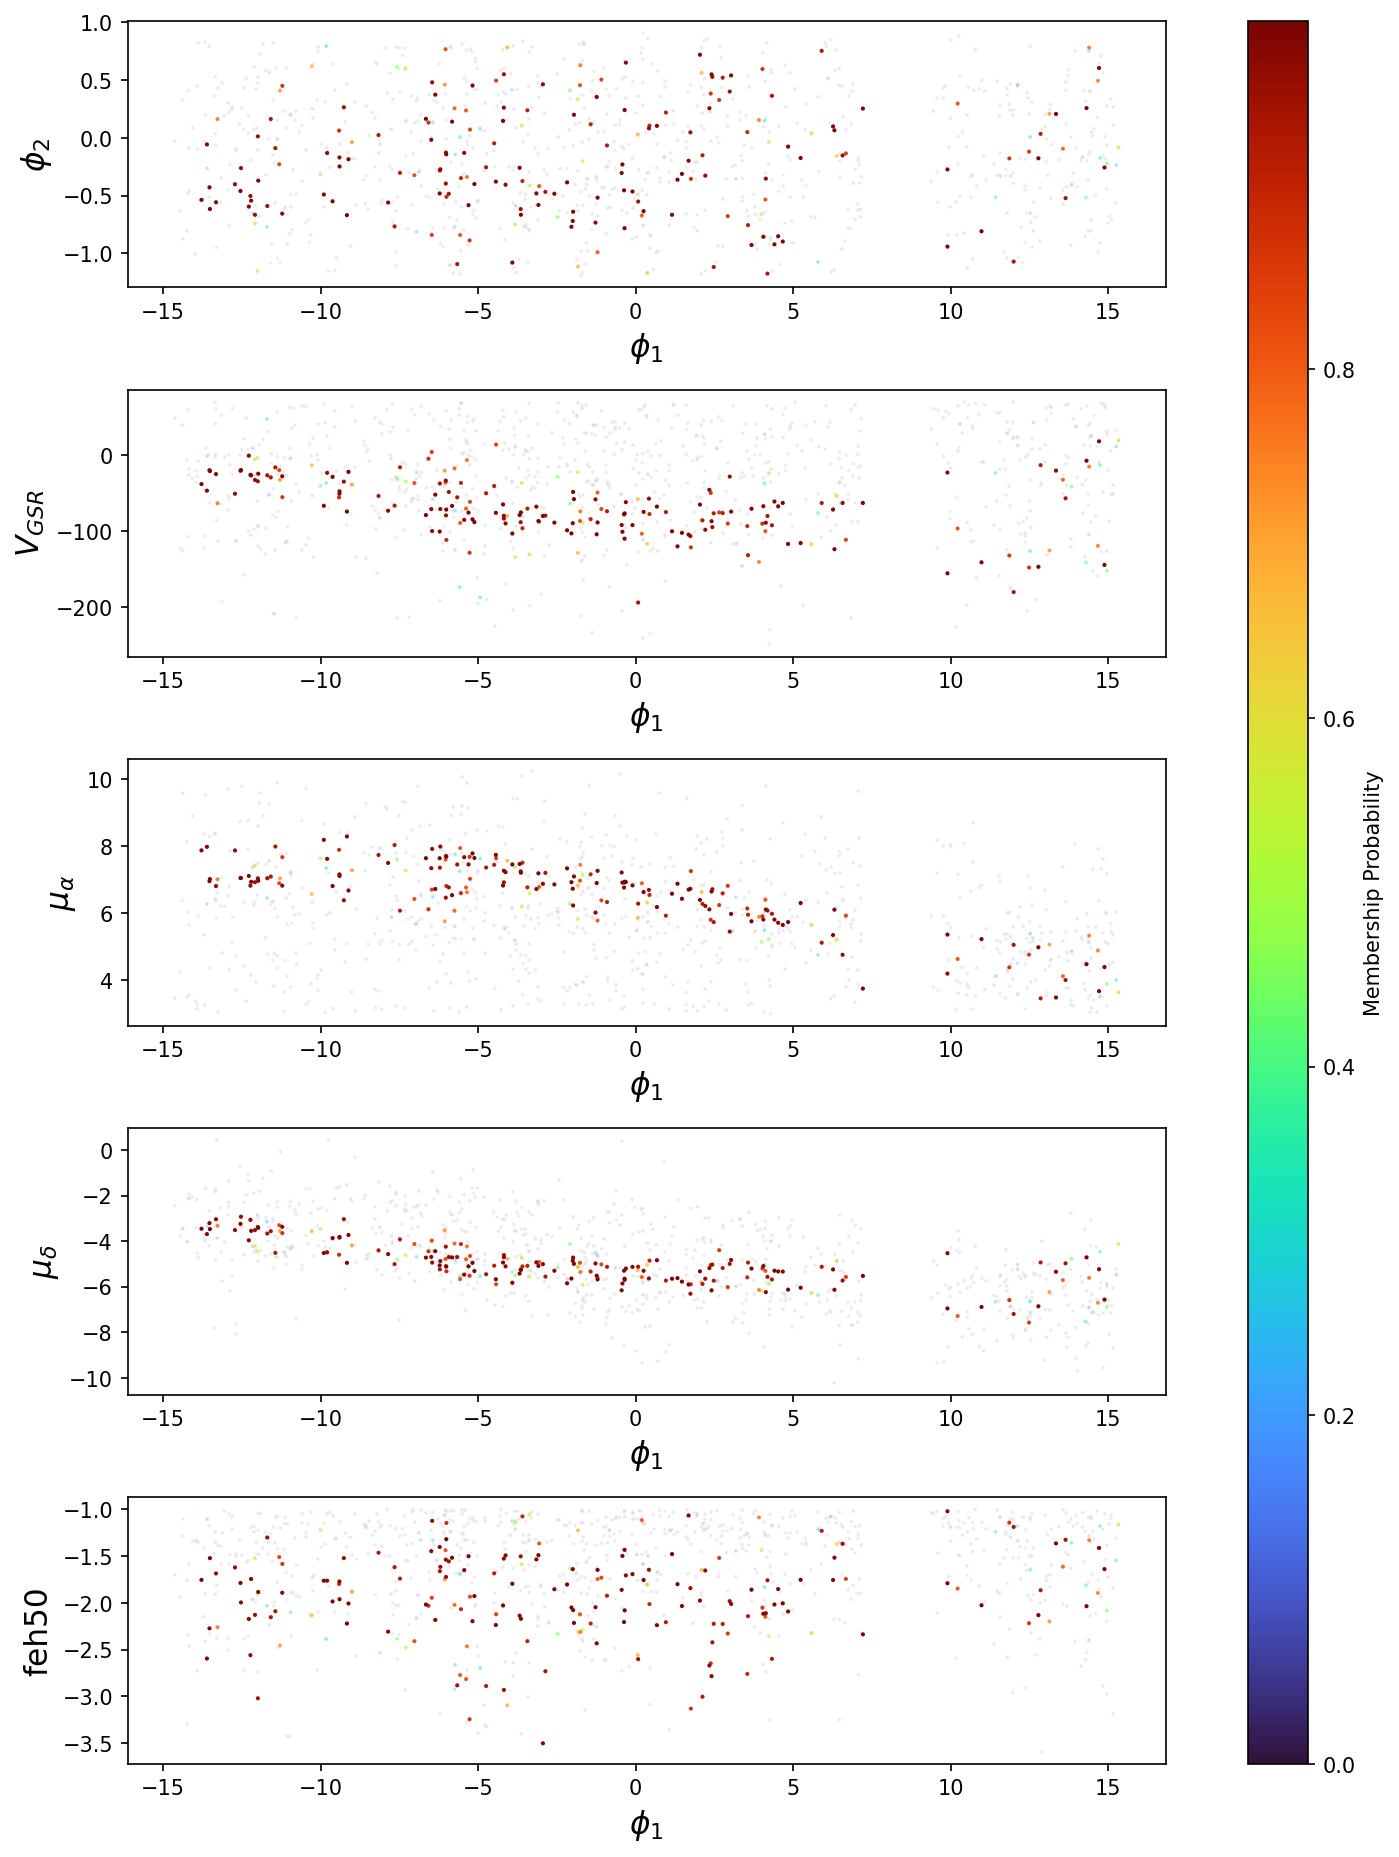

In [55]:
fig = smlvis.component_likelihood(
    jhelum_data_red, 
    stream_prob,
    coords=("phi2", "vgsr", "pmra", "pmdec", "feh50"),
    savefig=folder / f"tot_stream_prob_all.pdf",
);
fig.set_dpi(150)
s1 = fig.get_axes()[0].scatter(jhelum_data_red['phi1'], jhelum_data_red['phi2'], c=stream_prob, cmap='turbo',  marker='.', alpha=1, label='ML Model Probable Members', visible=False)
gs2 = plt.GridSpec(1, 1, left=1.05, right=1.10, hspace=0.05, height_ratios=[0.1,])
ax4 = fig.add_subplot(gs2[0,0])
axs = fig.get_axes()
axs[1].set_ylabel('$V_{\t{GSR}}$')
fig.colorbar(s1, label='Membership Probability', cax=ax4, orientation='vertical')

Individual

Stream 1

In [56]:
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream1_lnlik = model.component_ln_likelihood("stream1", mpars, data, where=where)
    tot_lnlik1 = model.ln_likelihood(mpars, data, where=where)

stream1_prob = np.exp((stream1_lnlik) - tot_lnlik1)
print(stream1_prob.min(), stream1_prob.max())
stream1_prob[stream1_prob > 1] = 1.0

tensor(0.) tensor(1.)


In [57]:
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream2_lnlik = model.component_ln_likelihood("stream2", mpars, data, where=where)
    tot_lnlik2 = model.ln_likelihood(mpars, data, where=where)

stream2_prob = np.exp((stream2_lnlik) - tot_lnlik2)
print(stream2_prob.min(), stream2_prob.max())
stream2_prob[stream2_prob > 1] = 1.0

tensor(0.) tensor(0.9988)


In [58]:
test = jhelum_data_red[stream_prob.numpy() > 0.95]
test_s1 = jhelum_data_red[stream1_prob.numpy() > 0.95]
test_s2 = jhelum_data_red[stream2_prob.numpy() > 0.95]

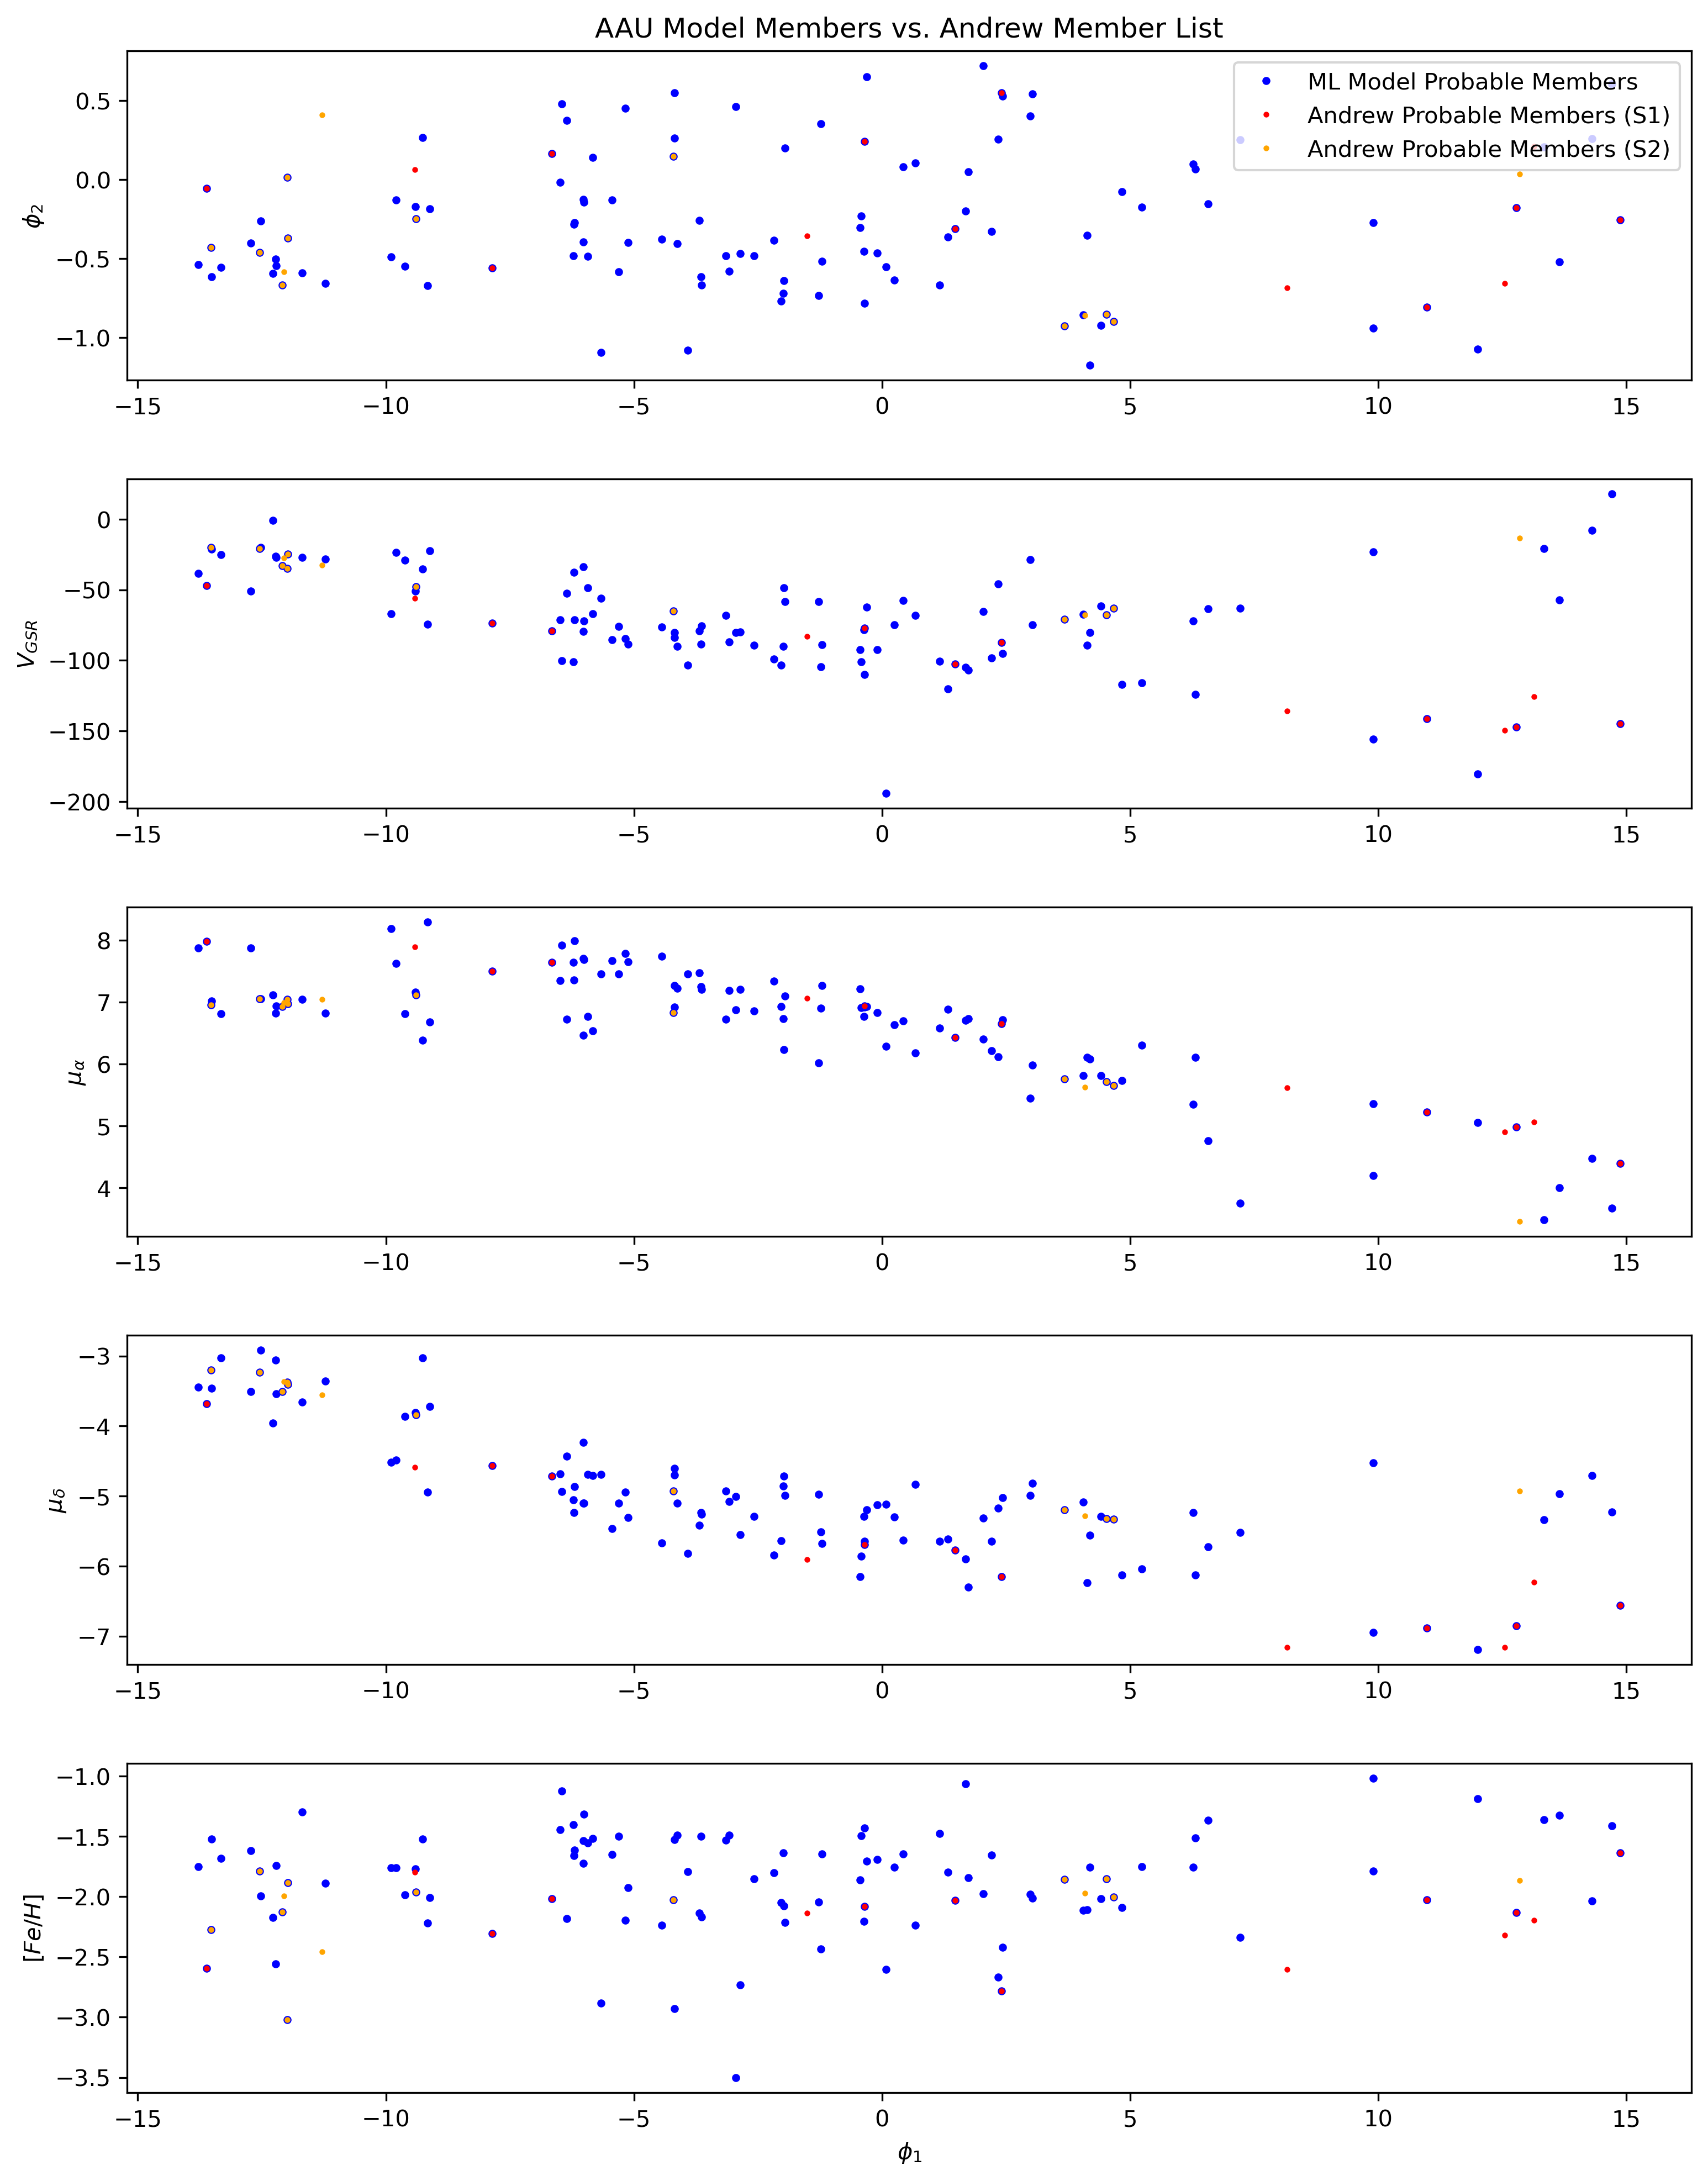

In [59]:
fig = plt.figure(dpi=300, figsize=(8,16))

gs1 = plt.GridSpec(5, 1, left=0.05, right=1.23, hspace=0.30)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
ax4 = fig.add_subplot(gs1[3,0])
ax5 = fig.add_subplot(gs1[4,0])

ax1.plot(test['phi1'], test['phi2'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5, label='ML Model Probable Members')
ax1.plot(s1_mem['phi1'], s1_mem['phi2'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3, label='Andrew Probable Members (S1)')
ax1.plot(s2_mem['phi1'], s2_mem['phi2'],
         c="orange", marker='.', linestyle='none', alpha=1, ms=3, label='Andrew Probable Members (S2)')

ax2.plot(test['phi1'], test['vgsr'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax2.plot(s1_mem['phi1'], s1_mem['vgsr'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)
ax2.plot(s2_mem['phi1'], s2_mem['vgsr'],
         c="orange", marker='.', linestyle='none', alpha=1, ms=3)

ax3.plot(test['phi1'], test['pmra'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax3.plot(s1_mem['phi1'], s1_mem['pmra'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)
ax3.plot(s2_mem['phi1'], s2_mem['pmra'],
         c="orange", marker='.', linestyle='none', alpha=1, ms=3)

ax4.plot(test['phi1'], test['pmdec'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax4.plot(s1_mem['phi1'], s1_mem['pmdec'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)
ax4.plot(s2_mem['phi1'], s2_mem['pmdec'],
         c="orange", marker='.', linestyle='none', alpha=1, ms=3)

ax5.plot(test['phi1'], test['feh50'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax5.plot(s1_mem['phi1'], s1_mem['feh50'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)
ax5.plot(s2_mem['phi1'], s2_mem['feh50'],
         c="orange", marker='.', linestyle='none', alpha=1, ms=3)


# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\\mu_{\\alpha}$')
ax4.set_ylabel('$\\mu_{\\delta}$')
ax5.set_ylabel('$[Fe/H]$')
ax5.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model Members vs. Andrew Member List')
ax1.legend()

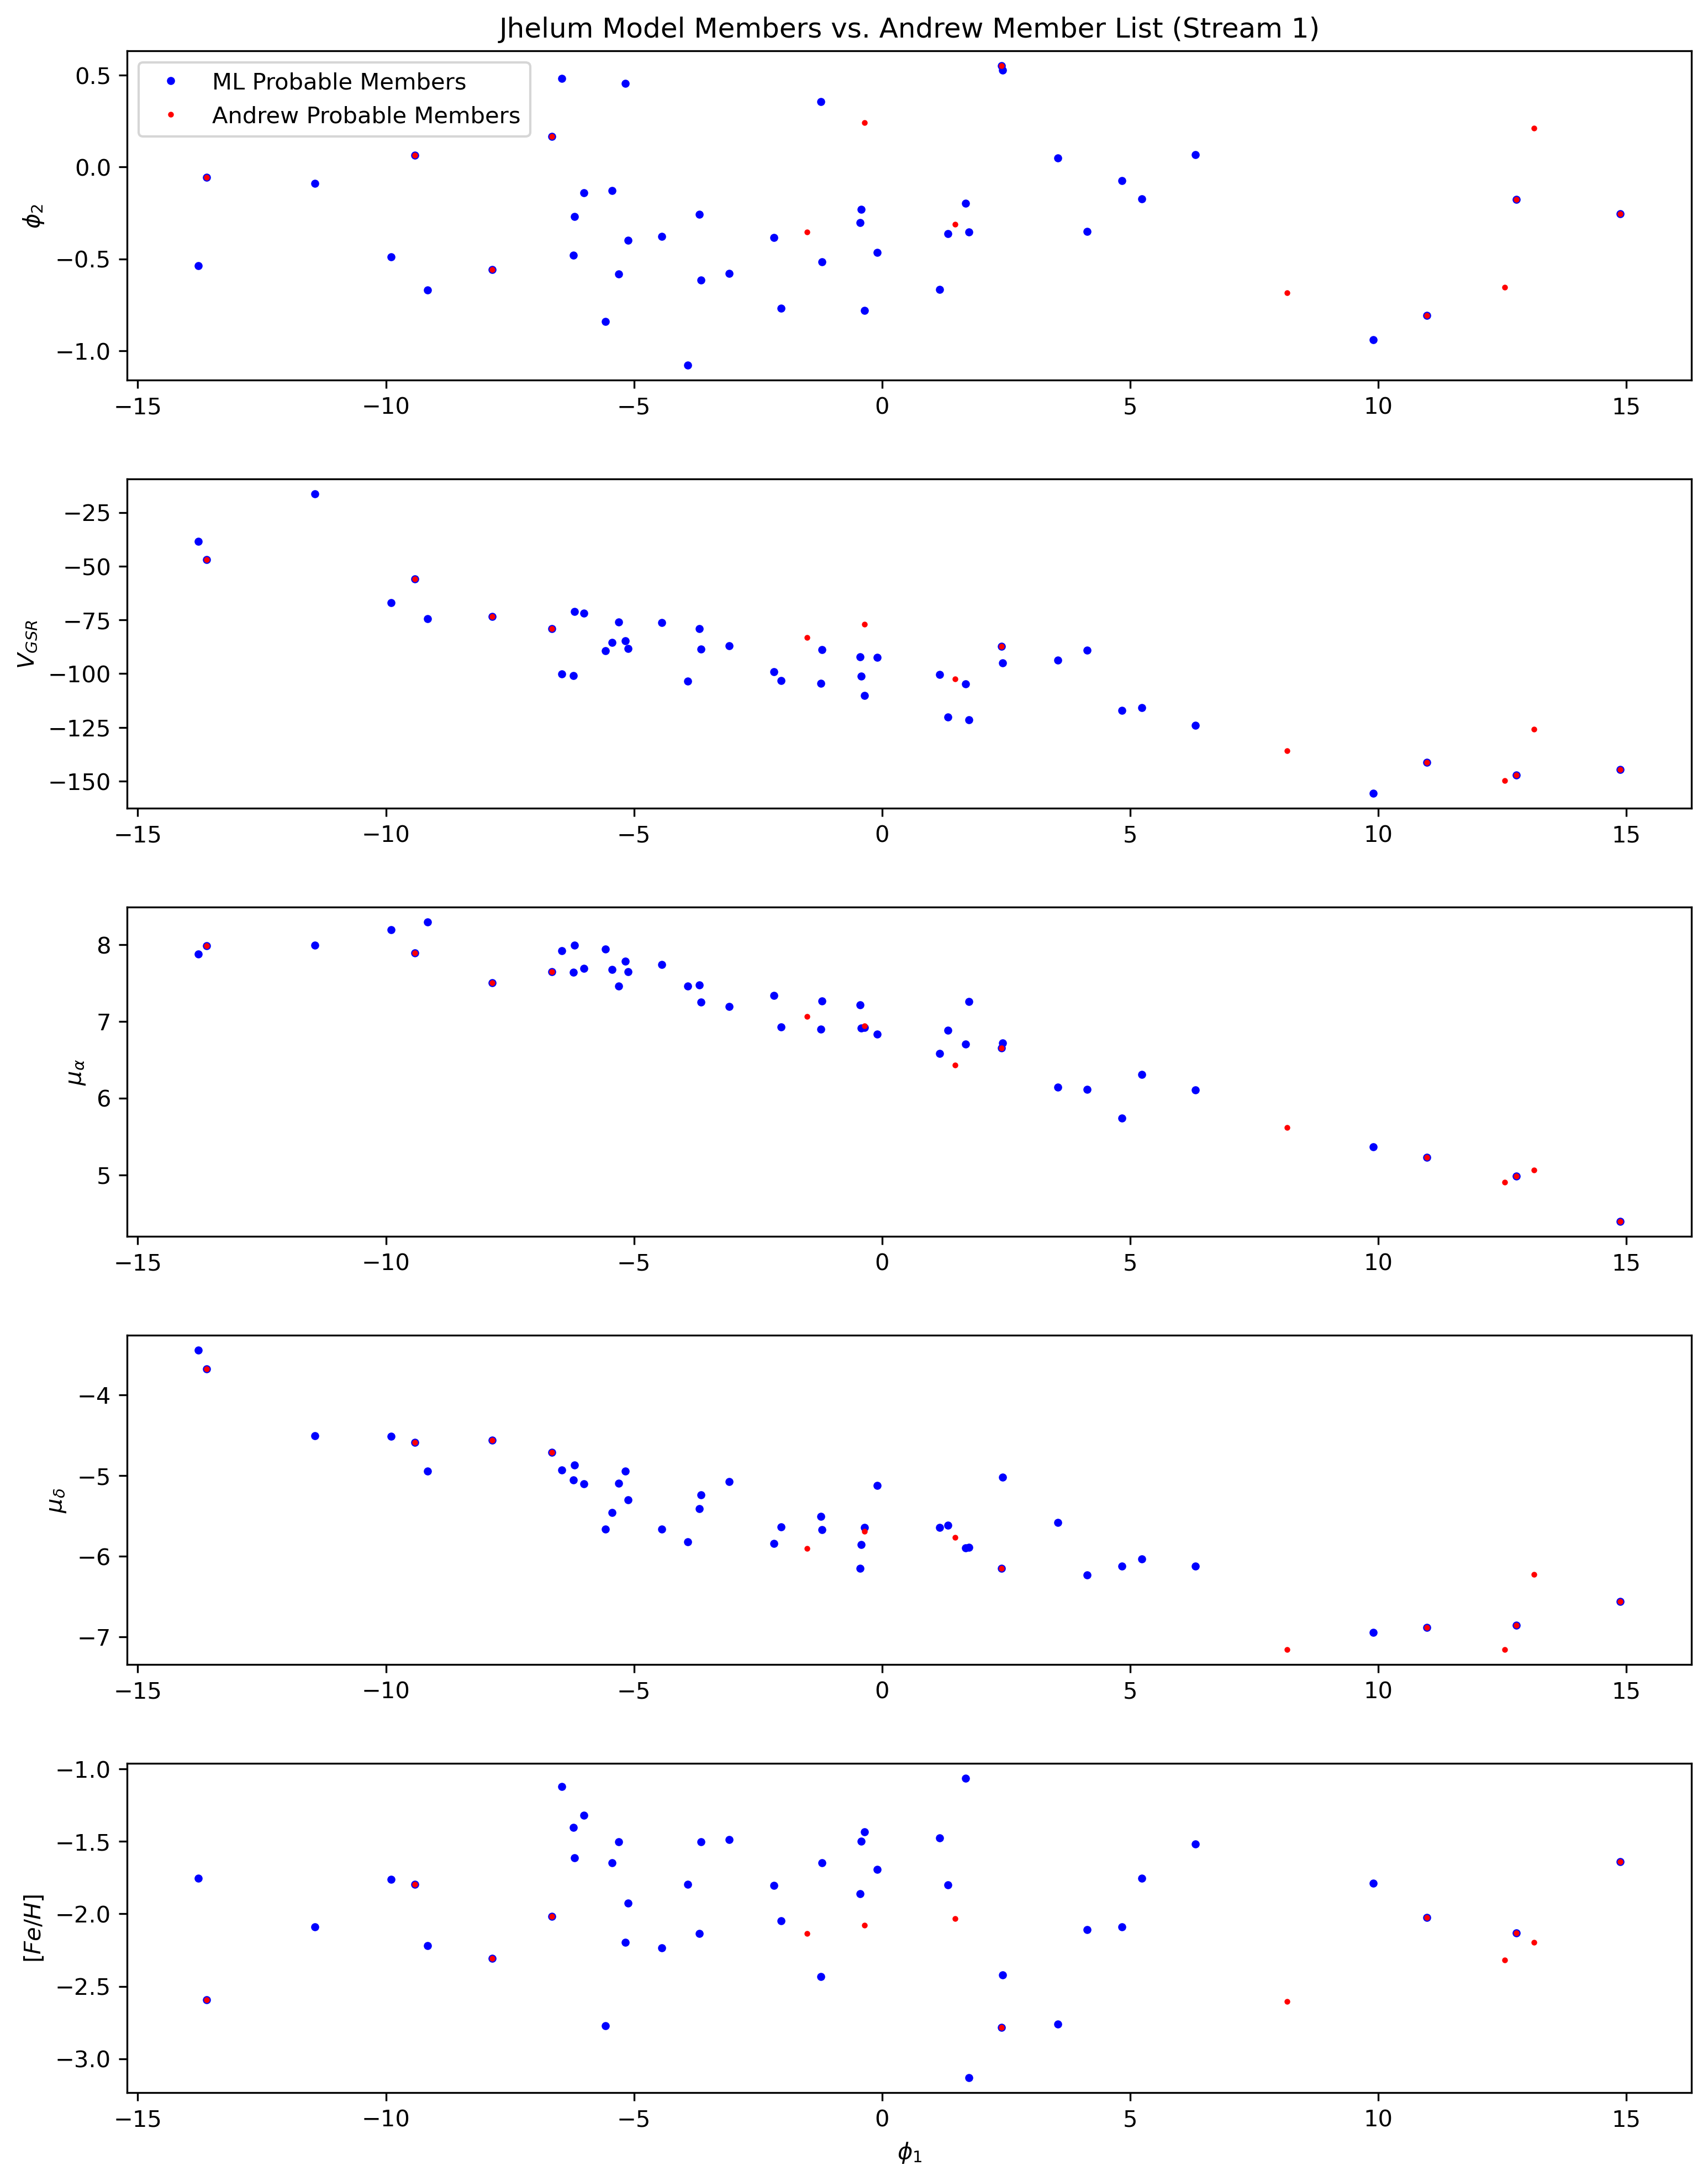

In [60]:
fig = plt.figure(dpi=300, figsize=(8,16))

gs1 = plt.GridSpec(5, 1, left=0.05, right=1.23, hspace=0.30)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
ax4 = fig.add_subplot(gs1[3,0])
ax5 = fig.add_subplot(gs1[4,0])

ax1.plot(test_s1['phi1'], test_s1['phi2'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5, label='ML Probable Members')
ax1.plot(s1_mem['phi1'], s1_mem['phi2'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3, label='Andrew Probable Members')


ax2.plot(test_s1['phi1'], test_s1['vgsr'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax2.plot(s1_mem['phi1'], s1_mem['vgsr'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


ax3.plot(test_s1['phi1'], test_s1['pmra'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax3.plot(s1_mem['phi1'], s1_mem['pmra'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


ax4.plot(test_s1['phi1'], test_s1['pmdec'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax4.plot(s1_mem['phi1'], s1_mem['pmdec'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


ax5.plot(test_s1['phi1'], test_s1['feh50'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax5.plot(s1_mem['phi1'], s1_mem['feh50'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\\mu_{\\alpha}$')
ax4.set_ylabel('$\\mu_{\\delta}$')
ax5.set_ylabel('$[Fe/H]$')
ax5.set_xlabel('$\\phi_1$')
ax1.set_title('Jhelum Model Members vs. Andrew Member List (Stream 1)')
ax1.legend()

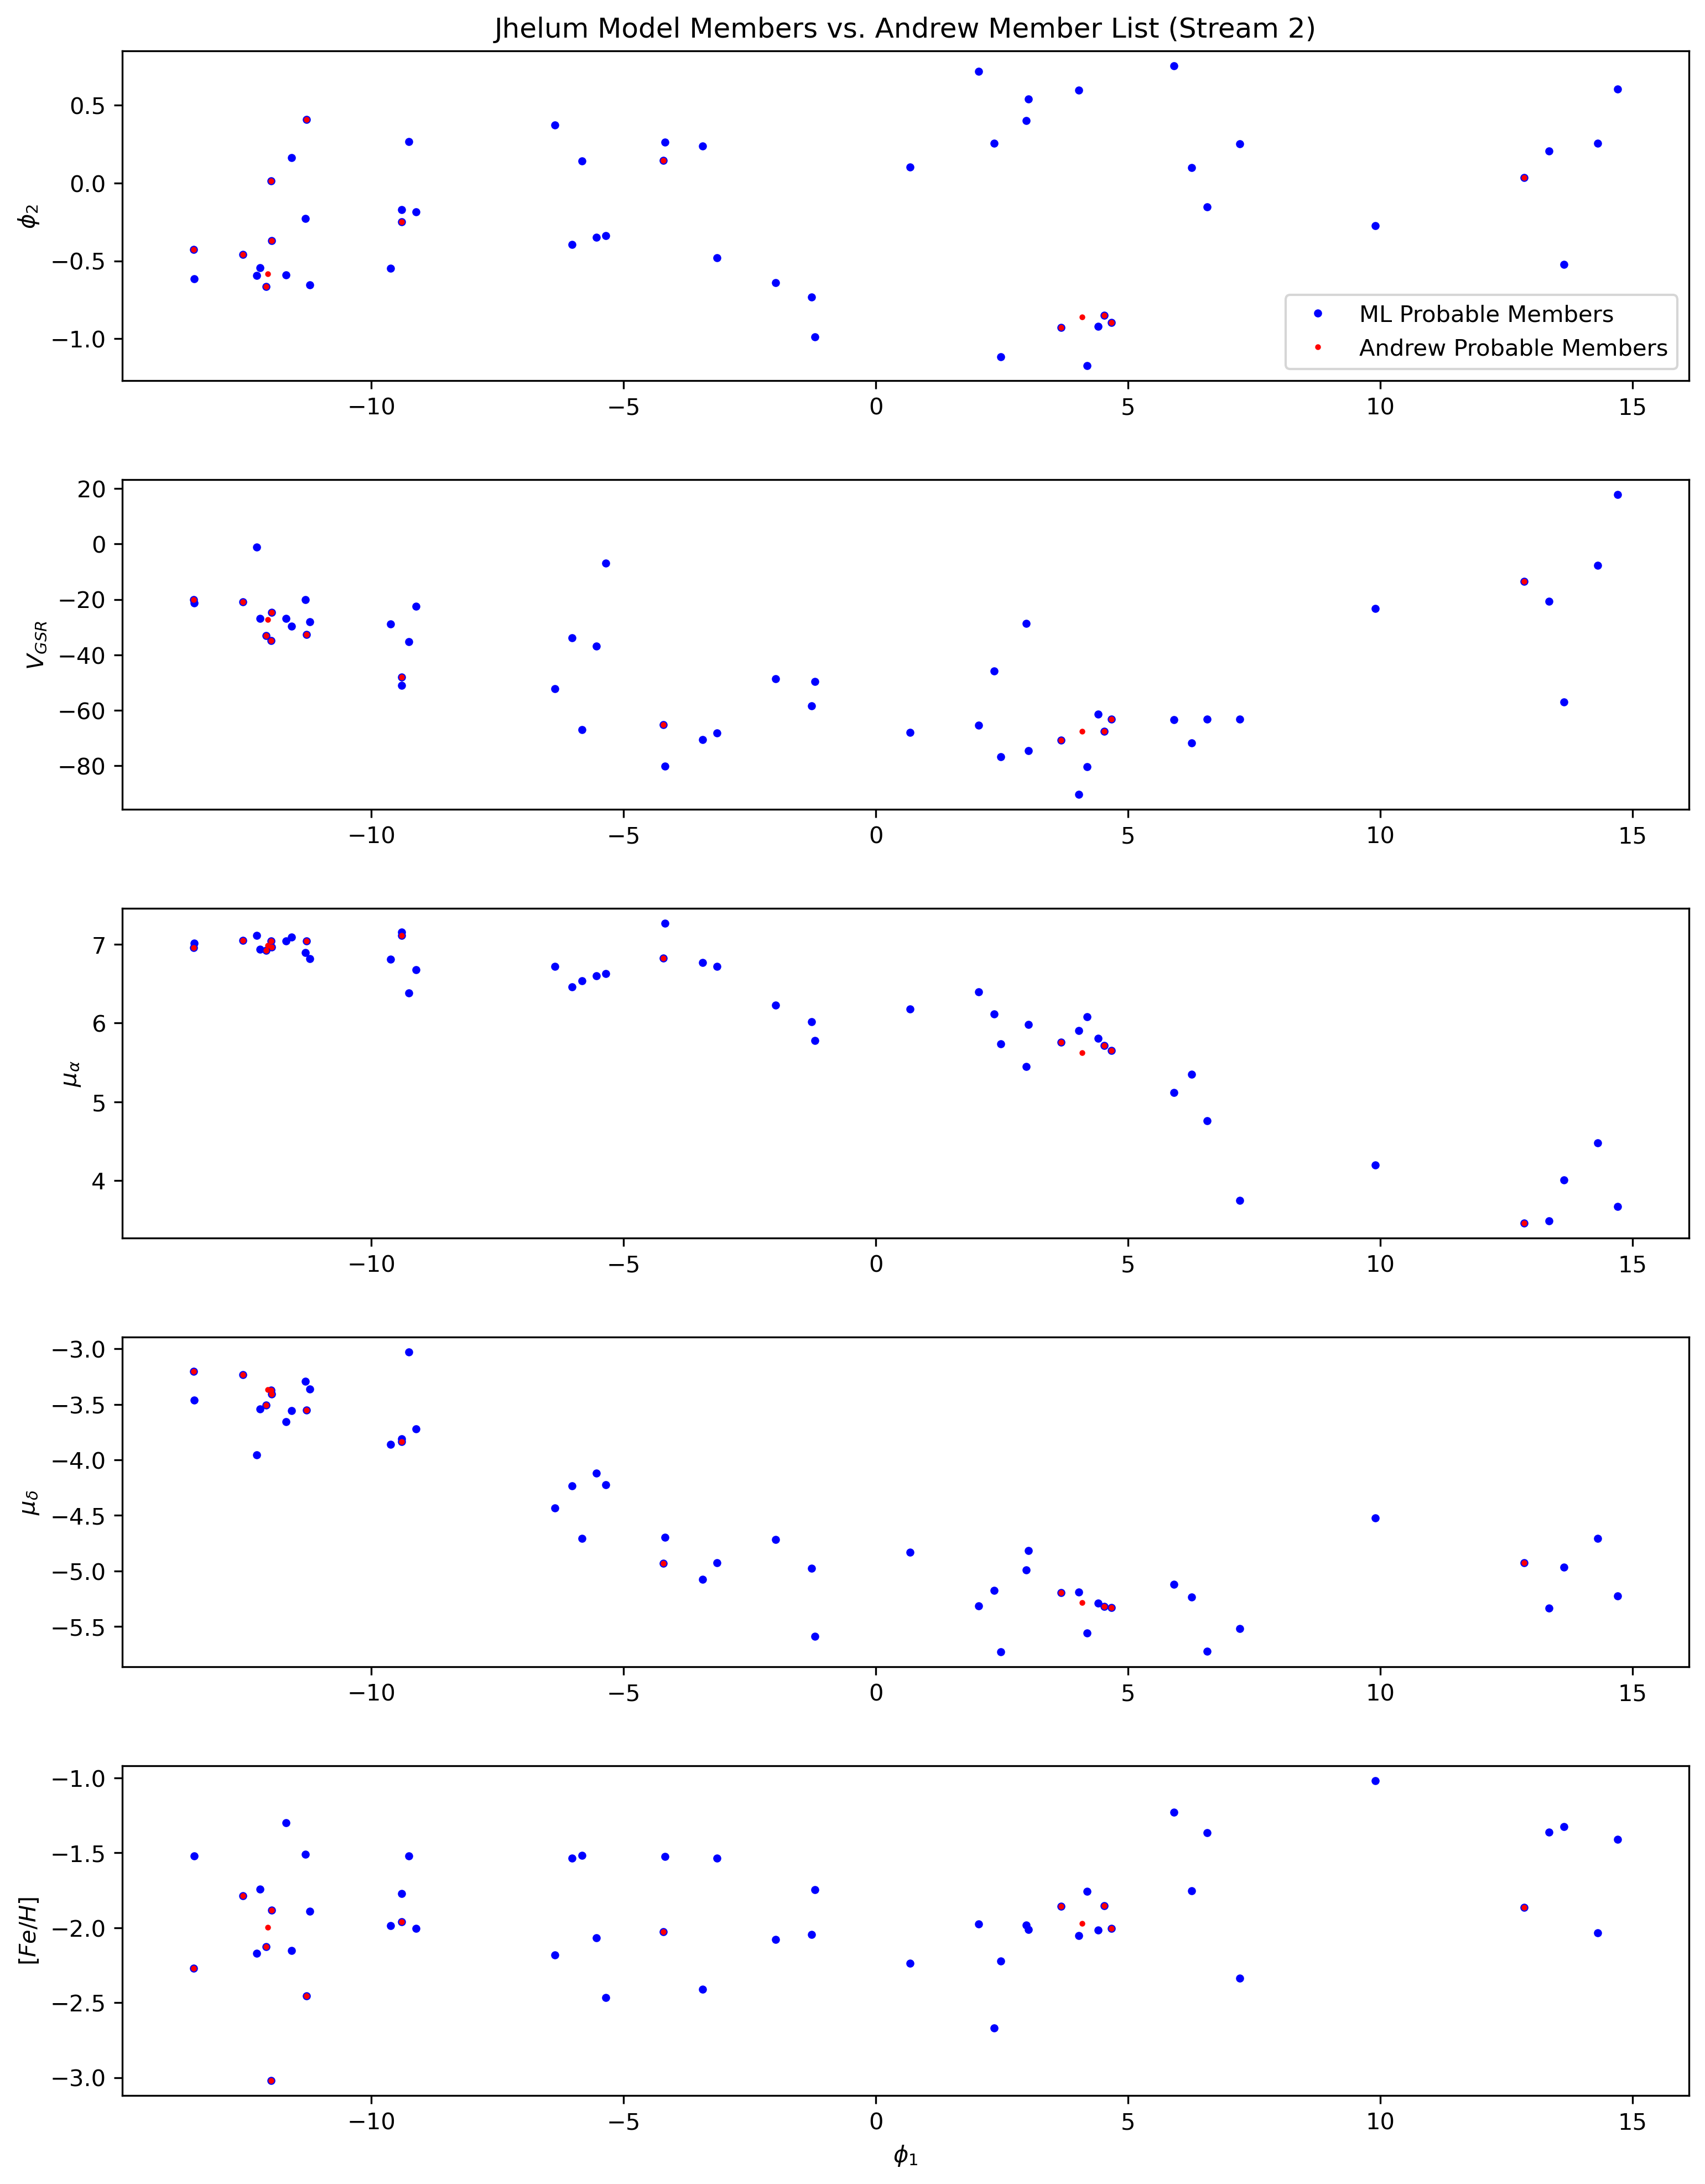

In [61]:
fig = plt.figure(dpi=300, figsize=(8,16))

gs1 = plt.GridSpec(5, 1, left=0.05, right=1.23, hspace=0.30)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
ax4 = fig.add_subplot(gs1[3,0])
ax5 = fig.add_subplot(gs1[4,0])

ax1.plot(test_s2['phi1'], test_s2['phi2'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5, label='ML Probable Members')
ax1.plot(s2_mem['phi1'], s2_mem['phi2'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3, label='Andrew Probable Members')


ax2.plot(test_s2['phi1'], test_s2['vgsr'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax2.plot(s2_mem['phi1'], s2_mem['vgsr'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


ax3.plot(test_s2['phi1'], test_s2['pmra'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax3.plot(s2_mem['phi1'], s2_mem['pmra'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


ax4.plot(test_s2['phi1'], test_s2['pmdec'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax4.plot(s2_mem['phi1'], s2_mem['pmdec'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


ax5.plot(test_s2['phi1'], test_s2['feh50'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax5.plot(s2_mem['phi1'], s2_mem['feh50'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\\mu_{\\alpha}$')
ax4.set_ylabel('$\\mu_{\\delta}$')
ax5.set_ylabel('$[Fe/H]$')
ax5.set_xlabel('$\\phi_1$')
ax1.set_title('Jhelum Model Members vs. Andrew Member List (Stream 2)')
ax1.legend()

## Stream 1 Plots

In [62]:
outp = []
for val in test_s1['phi2']:
    idx2 = np.where(jhelum_data_red['phi2'] == val)[0][0]
    idx2 = int(idx2)
    outp.append(idx2)
outp = np.array(outp)

In [63]:
model.train()
phi2_samples_mu = []
rv_samples_mu = []
pmra_samples_mu = []
pmdec_samples_mu = []

phi2_samples_sigma = []
rv_samples_sigma = []
pmra_samples_sigma = []
pmdec_samples_sigma = []
with xp.no_grad():
    for i in range(100):
        mpars = model.unpack_params(model(data))
        phi2_samples_mu.append(mpars['stream1.astrometric.phi2', 'mu'])
        rv_samples_mu.append(mpars['stream1.astrometric.rv', 'mu'])
        pmra_samples_mu.append(mpars['stream1.astrometric.pmra', 'mu'])
        pmdec_samples_mu.append(mpars['stream1.astrometric.pmdec', 'mu'])
        
        phi2_samples_sigma.append(mpars['stream1.astrometric.phi2', 'ln-sigma'])
        rv_samples_sigma.append(mpars['stream1.astrometric.rv', 'ln-sigma'])
        pmra_samples_sigma.append(mpars['stream1.astrometric.pmra', 'ln-sigma'])
        pmdec_samples_sigma.append(mpars['stream1.astrometric.pmdec', 'ln-sigma'])

        
abce = []
for i in range(len(data['phi1'])):
    hlp = []
    for j in range(100):
        hlp.append(rv_samples_mu[j][i])
    abce.append(np.percentile(hlp, 95)-np.percentile(hlp, 5))
abce = np.array(abce)

In [64]:
model.eval()
with xp.no_grad():
    mpars = model.unpack_params(model(data))

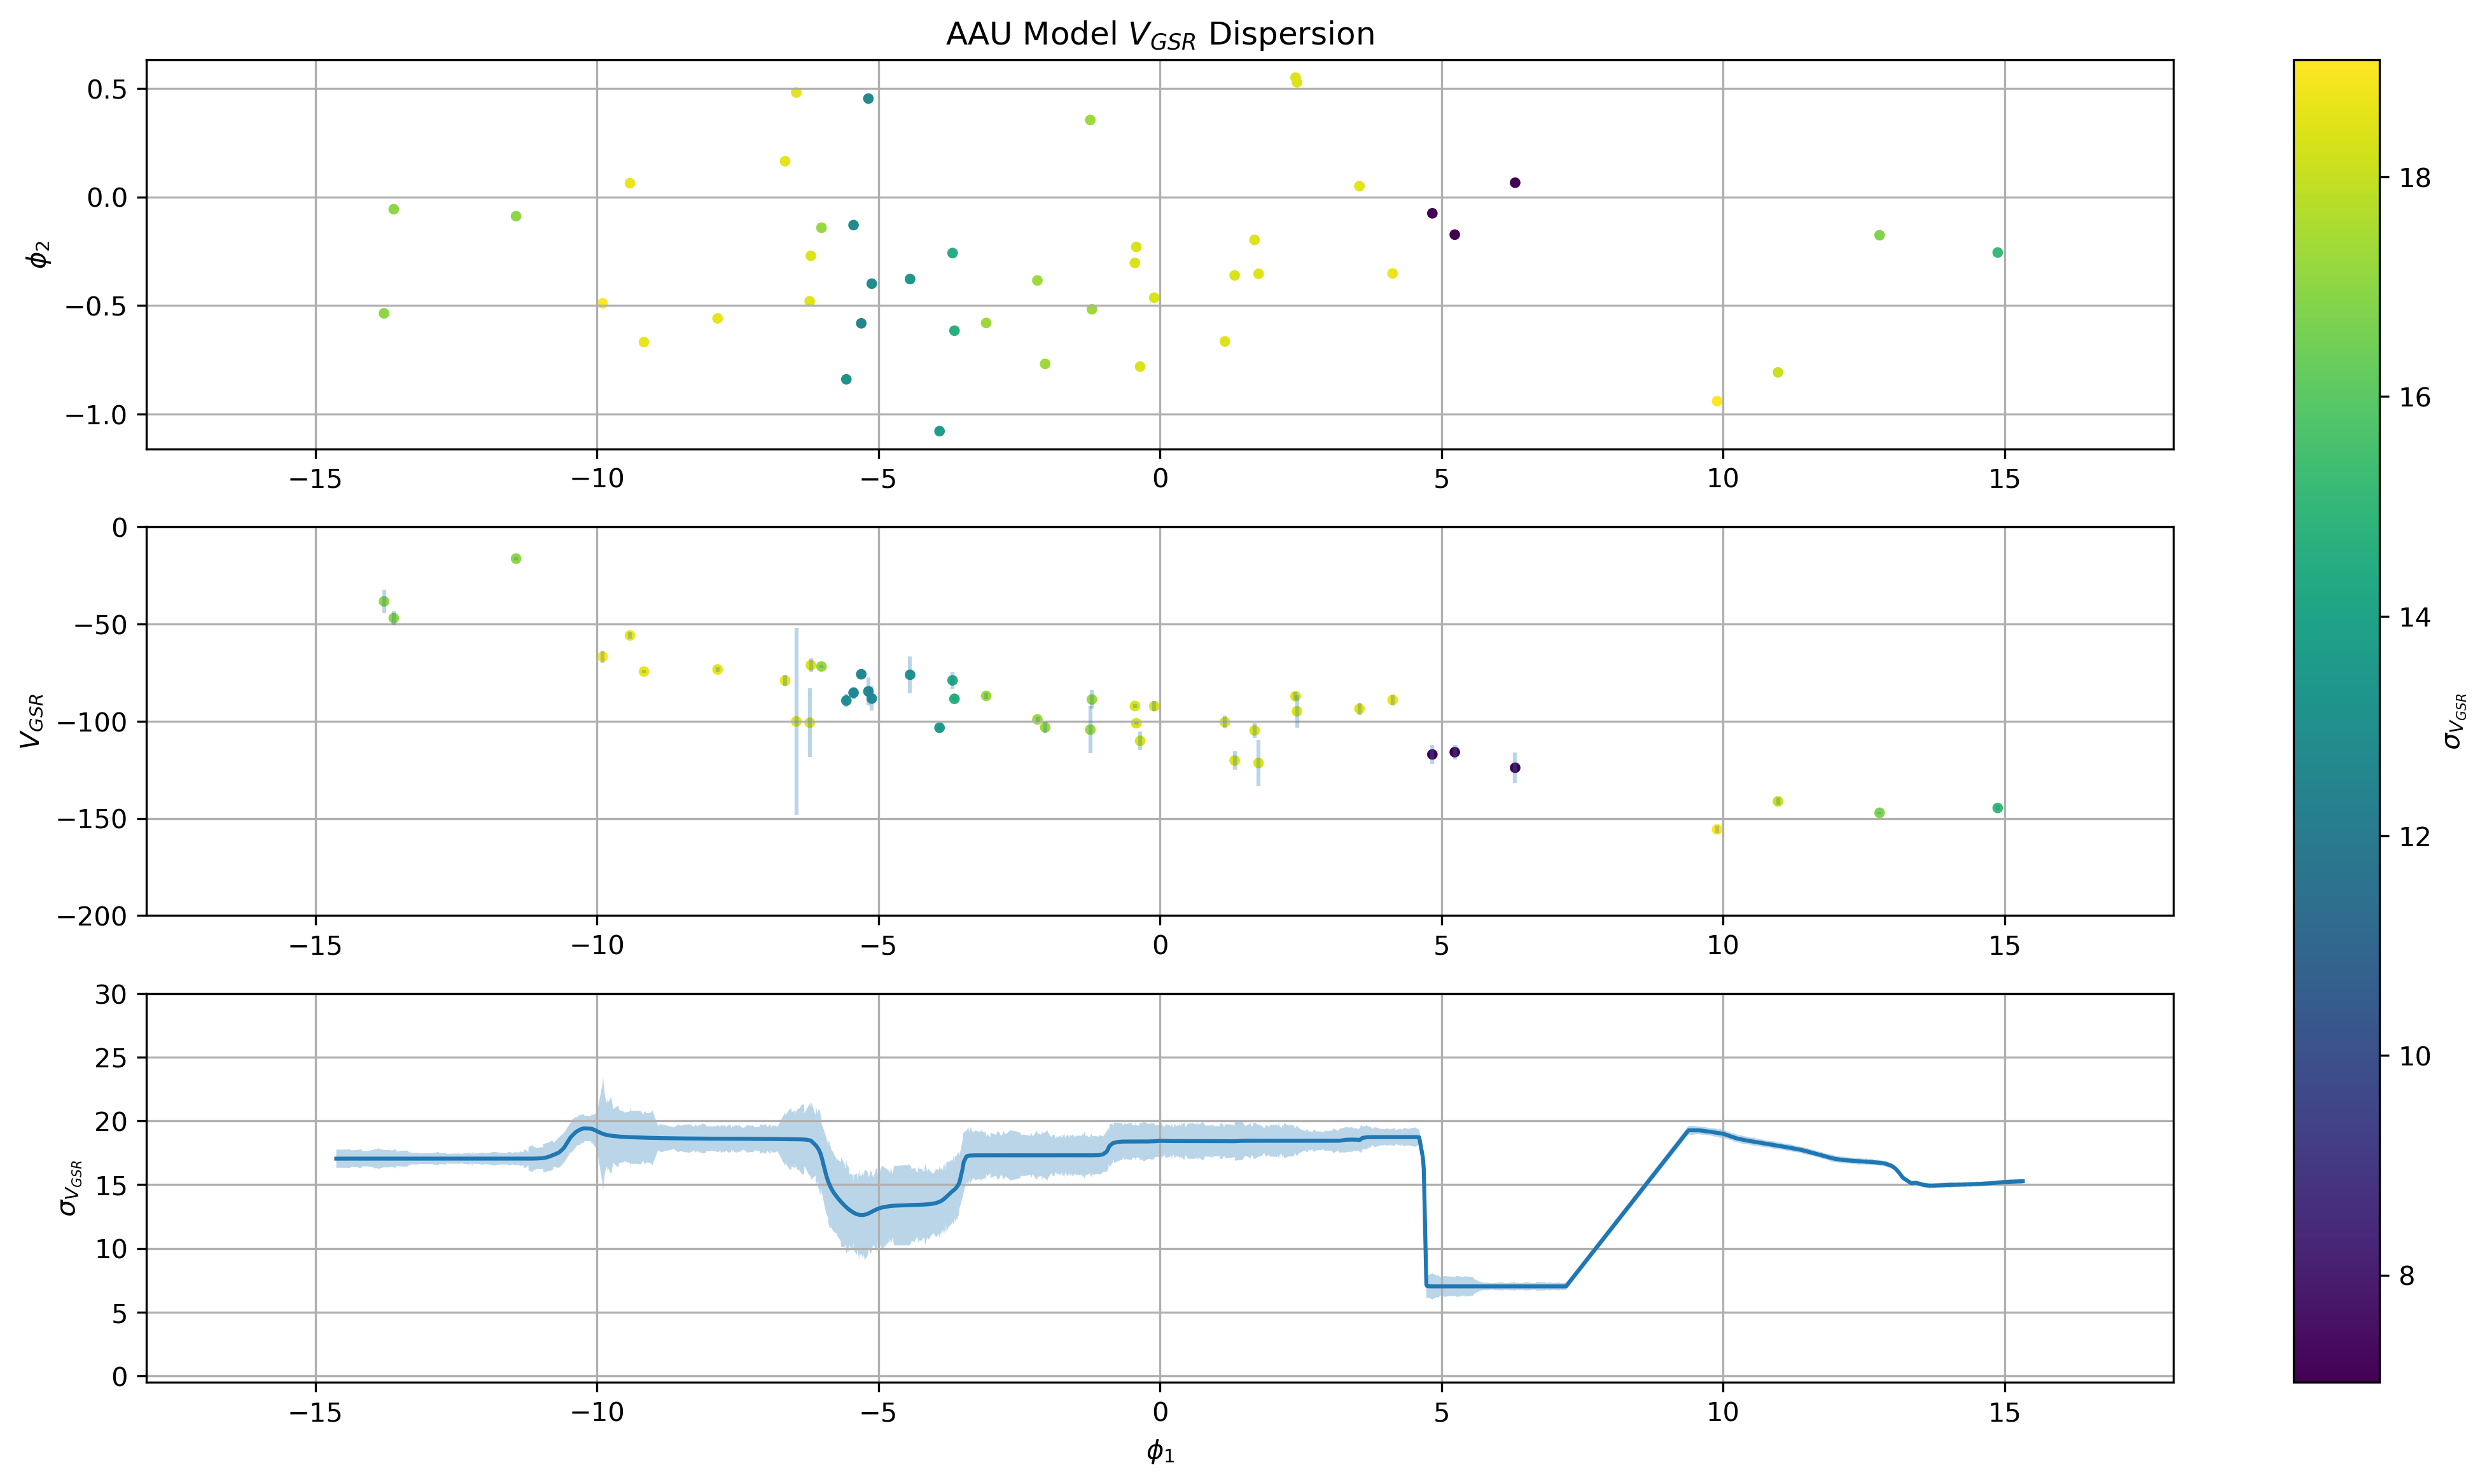

In [65]:
# Plot Setup
fig = plt.figure(dpi=300, figsize=(9,9))

gs1 = plt.GridSpec(3, 1, left=0.05, right=1.23, wspace=0.05)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
gs2 = plt.GridSpec(1, 1, left=1.30, right=1.35, hspace=0.05)
ax4 = fig.add_subplot(gs2[0,0])

# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\sigma_{V_{\t{GSR}}}$')
ax3.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model $V_{\t{GSR}}$ Dispersion')

# Plotting
t1 = ax1.scatter(test_s1['phi1'], test_s1['phi2'], c=np.exp(mpars['stream1.astrometric.rv', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members')
t2 = ax2.scatter(test_s1['phi1'], test_s1['vgsr'], c=np.exp(mpars['stream1.astrometric.rv', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members') 
ax2.errorbar(test_s1['phi1'].value, test_s1['vgsr'].value, yerr=test_s1['vel_calib_std'].value, fmt='none', alpha=0.3, label='ML Model Probable Members')


ax3.plot(data['phi1'], np.exp(mpars['stream1.astrometric.rv', 'ln-sigma']))
fig.colorbar(t1, label='$\sigma_{V_{\t{GSR}}}$', cax=ax4, orientation='vertical')

temp = np.exp(mpars['stream1.astrometric.rv', 'ln-sigma'])-mpars['stream1.weight']*abce
for i in range(len(temp)):
    if temp[i] < 0.:
        temp[i] = 0
ax3.fill_between(data['phi1'], temp, np.exp(mpars['stream1.astrometric.rv', 'ln-sigma'])+mpars['stream1.weight']*abce, alpha=0.3, interpolate=True )
#ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.rv', 'ln-sigma']+0.5*abce), alpha=0.3 )
# Axis Limits and Misc.
ax1.set_xlim((-18,18))
ax2.set_xlim((-18,18))
ax3.set_xlim((-18,18))
ax2.set_ylim((-200,0))
ax3.set_ylim((-0.5,30))
ax1.grid()
ax2.grid()
ax3.grid()


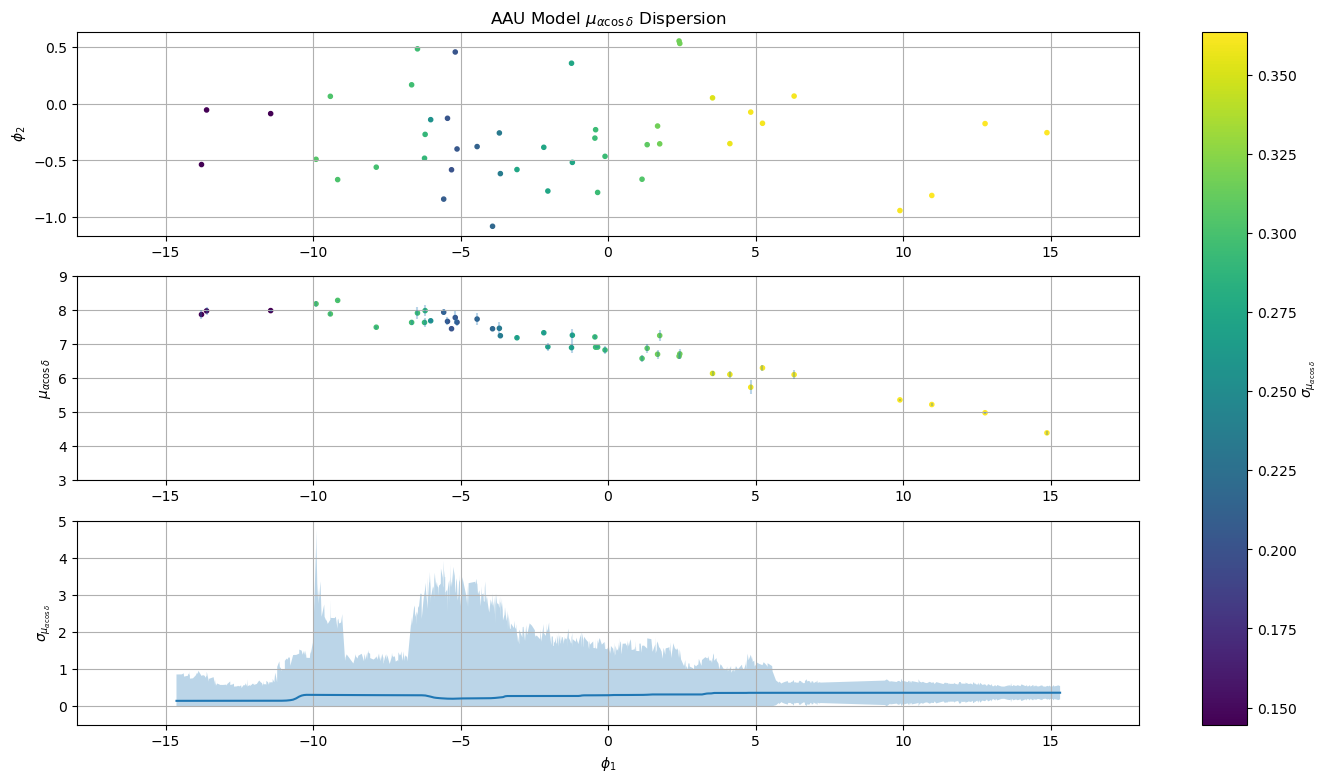

In [66]:
samples_2 = []
for i in range(len(data['phi1'])):
    hlp = []
    for j in range(100):
        hlp.append(rv_samples_mu[j][i])
    samples_2.append(np.percentile(hlp, 95)-np.percentile(hlp, 5))
samples_2 = np.array(samples_2)


# Plot Setup
fig = plt.figure(dpi=100, figsize=(9,9))

gs1 = plt.GridSpec(3, 1, left=0.05, right=1.23, wspace=0.05)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
gs2 = plt.GridSpec(1, 1, left=1.30, right=1.35, hspace=0.05)
ax4 = fig.add_subplot(gs2[0,0])

# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$\\mu_{\\alpha\\cos\\delta}$')
ax3.set_ylabel('$\\sigma_{\\mu_{\\alpha\\cos\\delta}}$')
ax3.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model $\\mu_{\\alpha\\cos\\delta}$ Dispersion')

# Plotting
t1 = ax1.scatter(test_s1['phi1'], test_s1['phi2'], c=np.exp(mpars['stream1.astrometric.pmra', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members')
t2 = ax2.scatter(test_s1['phi1'], test_s1['pmra'], c=np.exp(mpars['stream1.astrometric.pmra', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members') 
ax2.errorbar(np.array(test_s1['phi1'].value), np.array(test_s1['pmra'].value), yerr=np.array(test_s1['pmra_error'].value), fmt='none', alpha=0.3, label='ML Model Probable Members')


ax3.plot(data['phi1'], np.exp(mpars['stream1.astrometric.pmra', 'ln-sigma']))
fig.colorbar(t1, label='$\\sigma_{\\mu_{\\alpha\\cos\\delta}}$', cax=ax4, orientation='vertical')

temp = np.exp(mpars['stream1.astrometric.pmra', 'ln-sigma'])-mpars['stream1.weight']*samples_2
for i in range(len(temp)):
    if temp[i] < 0.:
        temp[i] = 0
ax3.fill_between(data['phi1'], temp, np.exp(mpars['stream1.astrometric.pmra', 'ln-sigma'])+mpars['stream1.weight']*samples_2, alpha=0.3, interpolate=True )
#ax3.plot(data['phi1'], np.exp(mpars['stream1.astrometric.rv', 'ln-sigma']+0.5*abce), alpha=0.3 )
# Axis Limits and Misc.
ax1.set_xlim((-18,18))
ax2.set_xlim((-18,18))
ax3.set_xlim((-18,18))
ax2.set_ylim((3,9))
ax3.set_ylim((-0.5,5))
ax1.grid()
ax2.grid()
ax3.grid()

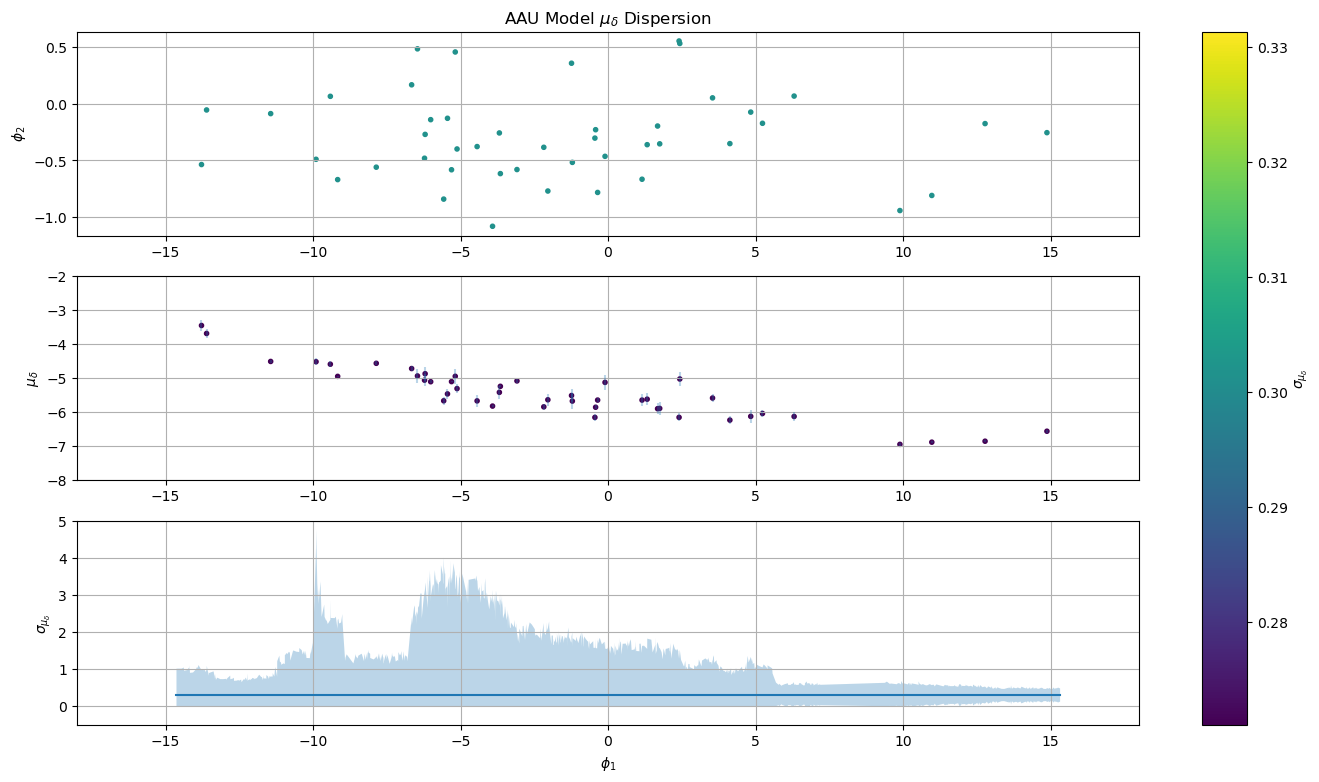

In [67]:
samples_2 = []
for i in range(len(data['phi1'])):
    hlp = []
    for j in range(100):
        hlp.append(rv_samples_mu[j][i])
    samples_2.append(np.percentile(hlp, 95)-np.percentile(hlp, 5))
samples_2 = np.array(samples_2)


# Plot Setup
fig = plt.figure(dpi=100, figsize=(9,9))

gs1 = plt.GridSpec(3, 1, left=0.05, right=1.23, wspace=0.05)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
gs2 = plt.GridSpec(1, 1, left=1.30, right=1.35, hspace=0.05)
ax4 = fig.add_subplot(gs2[0,0])

# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$\\mu_{\\delta}$')
ax3.set_ylabel('$\\sigma_{\\mu_{\\delta}}$')
ax3.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model $\\mu_{\\delta}$ Dispersion')

# Plotting
t1 = ax1.scatter(test_s1['phi1'], test_s1['phi2'], c=np.exp(mpars['stream1.astrometric.pmdec', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members')
t2 = ax2.scatter(test_s1['phi1'], test_s1['pmdec'], c=np.exp(mpars['stream1.astrometric.pmdec', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members') 
ax2.errorbar(np.array(test_s1['phi1'].value), np.array(test_s1['pmdec'].value), yerr=np.array(test_s1['pmdec_error'].value), fmt='none', alpha=0.3, label='ML Model Probable Members')


ax3.plot(data['phi1'], np.exp(mpars['stream1.astrometric.pmdec', 'ln-sigma']))
fig.colorbar(t1, label='$\\sigma_{\\mu_{\\delta}}$', cax=ax4, orientation='vertical')

temp = np.exp(mpars['stream1.astrometric.pmdec', 'ln-sigma'])-mpars['stream1.weight']*samples_2
for i in range(len(temp)):
    if temp[i] < 0.:
        temp[i] = 0
ax3.fill_between(data['phi1'], temp, np.exp(mpars['stream1.astrometric.pmdec', 'ln-sigma'])+mpars['stream1.weight']*samples_2, alpha=0.3, interpolate=True )
#ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.rv', 'ln-sigma']+0.5*abce), alpha=0.3 )
# Axis Limits and Misc.
ax1.set_xlim((-18,18))
ax2.set_xlim((-18,18))
ax3.set_xlim((-18,18))
ax2.set_ylim((-8,-2))
ax3.set_ylim((-0.5,5))
ax1.grid()
ax2.grid()
ax3.grid()

In [68]:
sel = (((jhelum_data_red['decam_g'].value - jhelum_data_red['decam_r'].value) > -1.0) 
       & ((jhelum_data_red['decam_g'].value - jhelum_data_red['decam_r'].value) < 1.5))

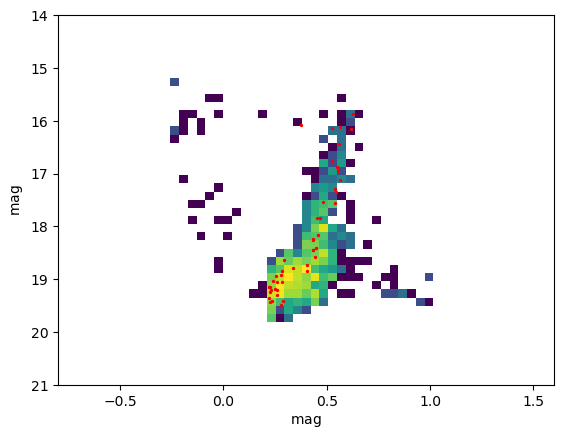

In [69]:
plt.hist2d((jhelum_data_red['decam_g'] - jhelum_data_red['decam_r'])[sel], jhelum_data_red['decam_g'][sel],
           bins=30, label='GD-1', norm=mcl.LogNorm())
plt.xlim((-0.8,1.6))
plt.ylim((21,14))
plt.scatter(test_s1['decam_g']-test_s1['decam_r'], test_s1['decam_g'], s=2, color='red')
plt.show()

## Stream 2 Plots

## New Plots

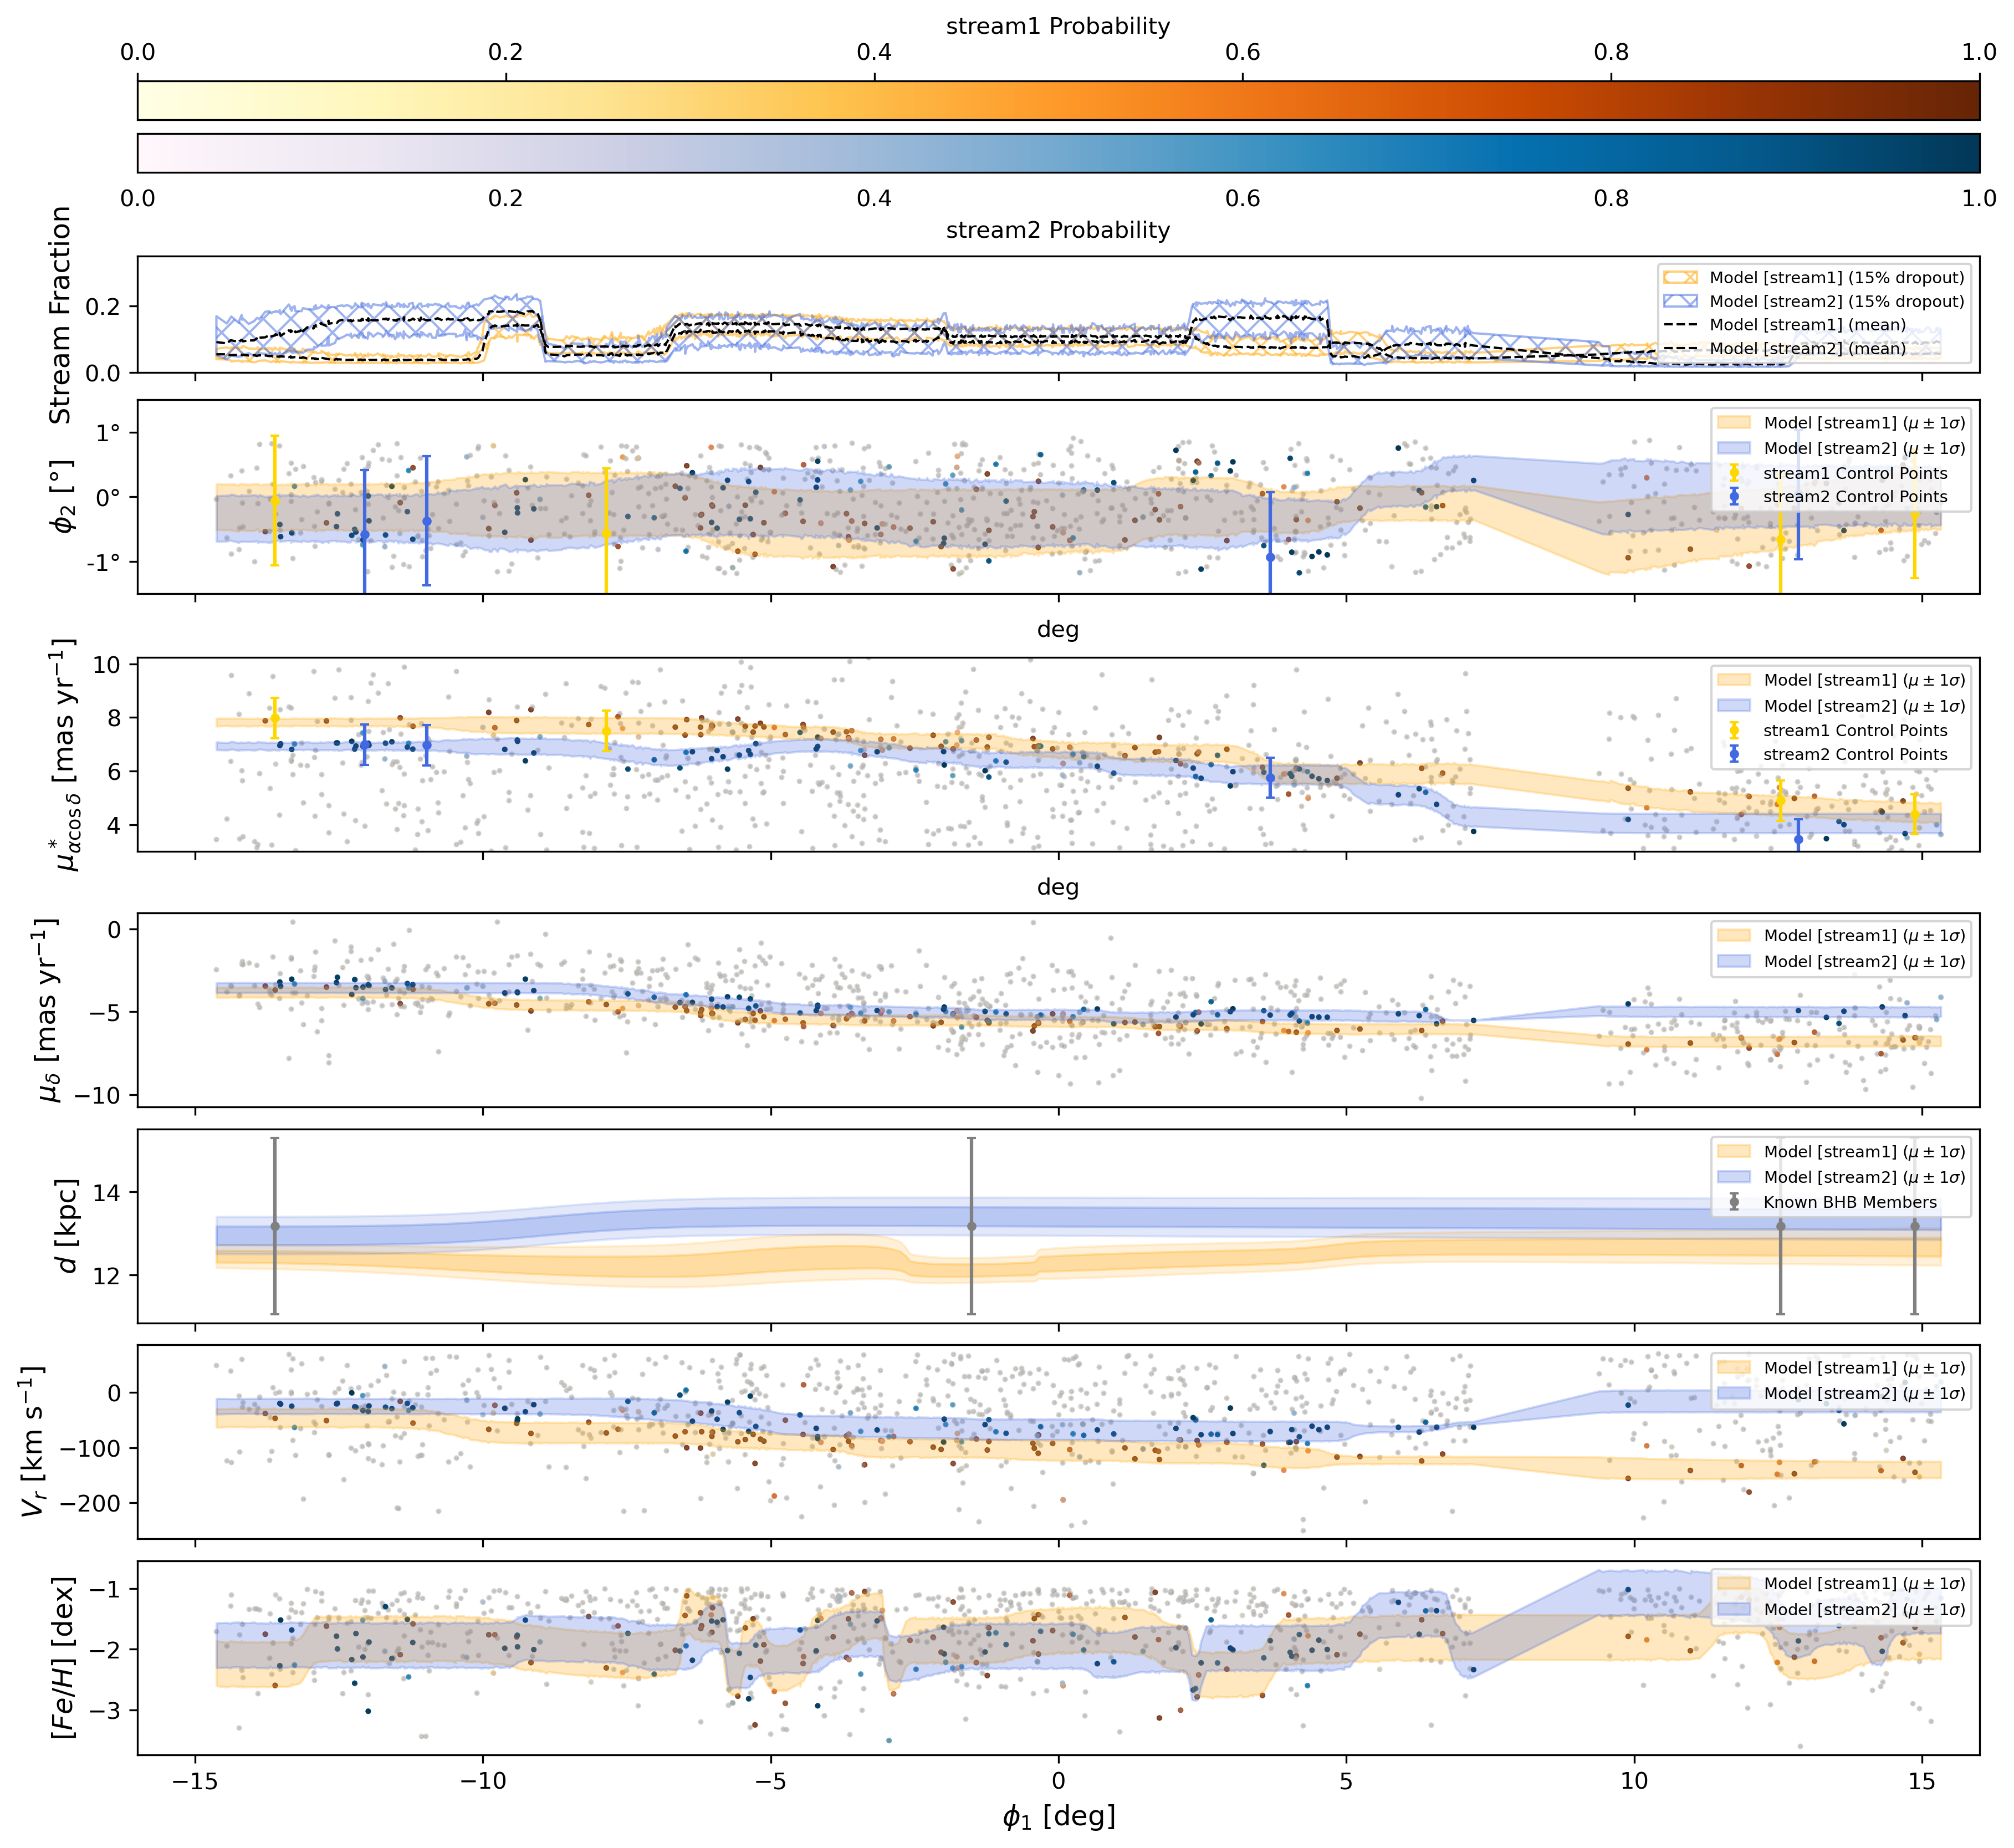

In [70]:
from helper2 import plot_stream
fig = plot_stream(model, data, where)
plt.show()
# Check metallicity

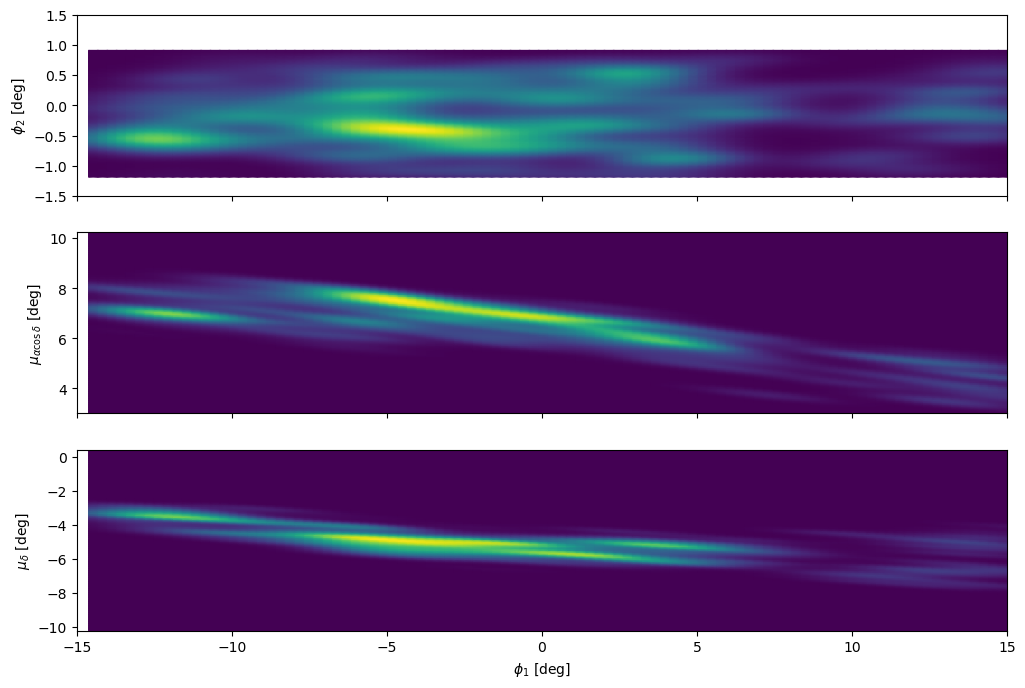

In [71]:
from helper3 import plot_stream_KDE_tot, plot_stream_KDE_s1, plot_stream_KDE_s2
plot_stream_KDE_tot(model, data, where)

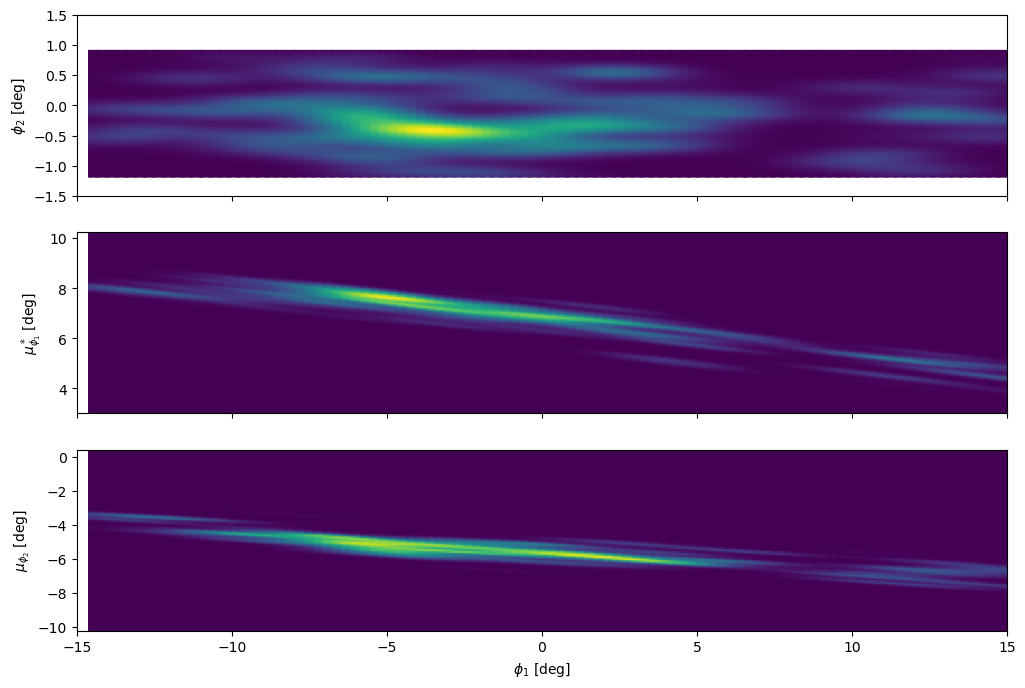

In [72]:
plot_stream_KDE_s1(model, data, where)

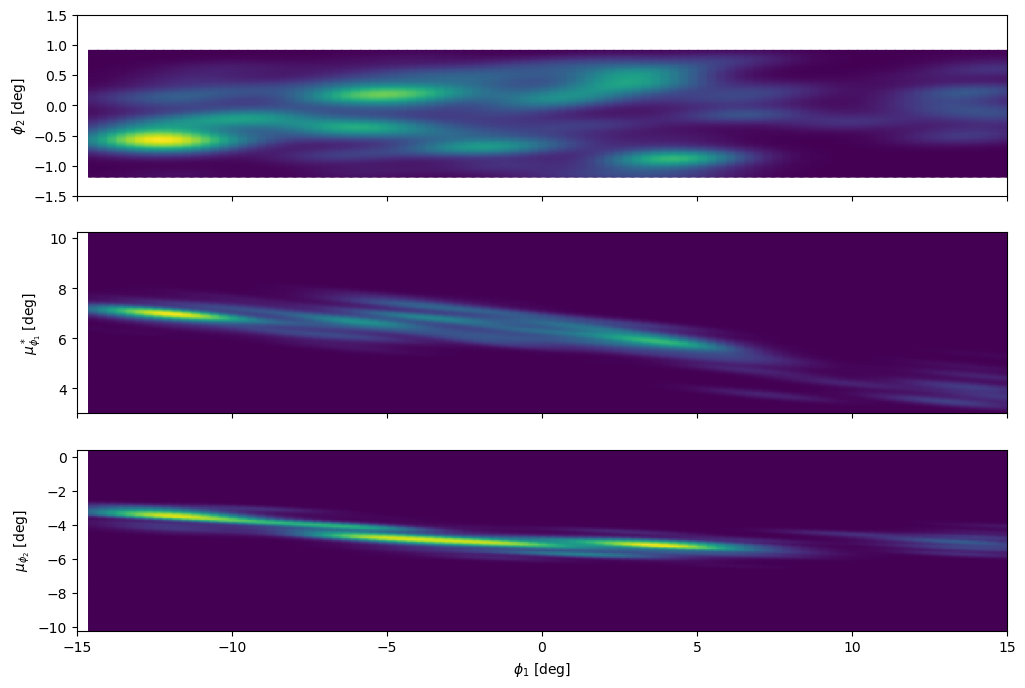

In [73]:
plot_stream_KDE_s2(model, data, where)